In [1]:
import os
os.chdir('/home/jovyan/work')
print(os.getcwd())

/home/jovyan/work


In [2]:
import argparse
import json
import pathlib
import contextlib
import random
import networkx as nx
import numpy as np
# from qiskit import QuantumCircuitav
from qiskit.converters import circuit_to_dagdependency

from compilation import is_qasm_file, manual_copy_dag, remove_node, update_sequence
from Cycles import GraphCreator, MemoryZone, get_idx_from_idc


In [3]:
# JSONファイルの読み込み
config_file = 'algorithms_heuristic/full_register_access_06.json'
config_file = 'algorithms_heuristic/qft_6.json'
with pathlib.Path(config_file).open("r") as f:
    config = json.load(f)

# 変数の設定
arch = config["arch"]
max_timesteps = config["max_timesteps"]
num_ion_chains = config["num_ion_chains"]
filename = config["qu_alg"]

print(f"Architecture: {arch}, Max Timesteps: {max_timesteps}, Number of Ion Chains: {num_ion_chains}")


Architecture: [3, 3, 1, 1], Max Timesteps: 50000, Number of Ion Chains: 6


In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from more_itertools import distinct_combinations, pairwise

exit (2, 2)
entry (2, 0)
parking_edge ((3, 3), (4, 3))
previous_exit_node (2, 2) exit_node (3, 3.0)
exit_edge ((2, 2), (3, 3.0))
previous_entry_node (2, 0) entry_node (3, 3.0)
entry_edge ((2, 0), (3, 3.0))
idc_dict {0: ((0, 0), (1, 0)), 1: ((0, 0), (0, 1)), 2: ((0, 1), (1, 1)), 3: ((0, 1), (0, 2)), 4: ((0, 2), (1, 2)), 5: ((1, 0), (2, 0)), 6: ((1, 0), (1, 1)), 7: ((1, 1), (2, 1)), 8: ((1, 1), (1, 2)), 9: ((1, 2), (2, 2)), 10: ((2, 0), (2, 1)), 11: ((2, 0), (3, 3.0)), 12: ((2, 1), (2, 2)), 13: ((2, 2), (3, 3.0)), 14: ((3, 3.0), (4, 3))}
path_to_pz_idxs [13]
path_from_pz_idxs [11]


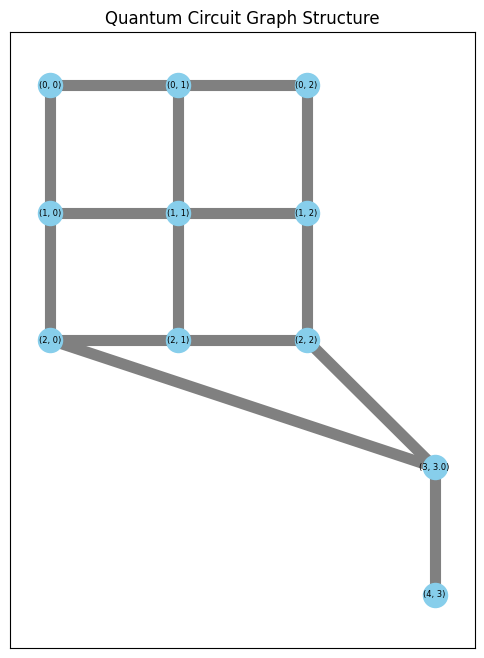

Number of traps: 12


In [5]:
m, n, v, h = arch
graph_creator = GraphCreator(m, n, v, h)
graph = graph_creator.get_graph()

# pos をカスタム設定
pos = {(x, y): (y, -x) for i, (x, y) in enumerate(list(graph.nodes()))}
# グラフの描画
plt.figure(figsize=(max(pos.keys())[1] * 2, max(pos.keys())[0] * 2))
nx.draw_networkx(
    graph,
    pos=pos,
    with_labels=True,
    node_size=300,
    node_color="skyblue",
    width=8,
    edge_color="gray",
    font_size=6,
)
plt.title("Quantum Circuit Graph Structure")
plt.show()

# トラップ数の確認
n_of_traps = len([trap for trap in graph.edges() if graph.get_edge_data(trap[0], trap[1])["edge_type"] == "trap"])
print(f"Number of traps: {n_of_traps}")

In [6]:
# for trap in graph.edges():
#     print(f"Trap {trap}: {graph.get_edge_data(trap[0], trap[1])}")

for node in graph.nodes(data=True):
    print(f"Node {node[0]}: {node[1]}")

Node (0, 0): {'node_type': 'junction_node', 'color': 'g'}
Node (0, 1): {'node_type': 'junction_node', 'color': 'g'}
Node (0, 2): {'node_type': 'junction_node', 'color': 'g'}
Node (1, 0): {'node_type': 'junction_node', 'color': 'g'}
Node (1, 1): {'node_type': 'junction_node', 'color': 'g'}
Node (1, 2): {'node_type': 'junction_node', 'color': 'g'}
Node (2, 0): {'node_type': 'junction_node', 'color': 'g'}
Node (2, 1): {'node_type': 'junction_node', 'color': 'g'}
Node (2, 2): {'node_type': 'junction_node', 'color': 'g'}
Node (3, 3.0): {'node_type': 'processing_zone_node', 'color': 'r'}
Node (4, 3): {'node_type': 'parking_node', 'color': 'r'}


In [7]:
from run_heuristic import create_starting_config
ion_chains, number_of_registers = create_starting_config(num_ion_chains, graph, n_of_traps, seed=None)

# 初期配置の可視化
for ion, pos in ion_chains.items():
    print(f"Ion {ion} starts at edge {pos}")

Ion 0 starts at edge ((0, 0), (1, 0))
Ion 1 starts at edge ((0, 0), (0, 1))
Ion 2 starts at edge ((0, 1), (1, 1))
Ion 3 starts at edge ((0, 1), (0, 2))
Ion 4 starts at edge ((0, 2), (1, 2))
Ion 5 starts at edge ((1, 0), (2, 0))


exit (2, 2)
entry (2, 0)
parking_edge ((3, 3), (4, 3))
previous_exit_node (2, 2) exit_node (3, 3.0)
exit_edge ((2, 2), (3, 3.0))
previous_entry_node (2, 0) entry_node (3, 3.0)
entry_edge ((2, 0), (3, 3.0))
idc_dict {0: ((0, 0), (1, 0)), 1: ((0, 0), (0, 1)), 2: ((0, 1), (1, 1)), 3: ((0, 1), (0, 2)), 4: ((0, 2), (1, 2)), 5: ((1, 0), (2, 0)), 6: ((1, 0), (1, 1)), 7: ((1, 1), (2, 1)), 8: ((1, 1), (1, 2)), 9: ((1, 2), (2, 2)), 10: ((2, 0), (2, 1)), 11: ((2, 0), (3, 3.0)), 12: ((2, 1), (2, 2)), 13: ((2, 2), (3, 3.0)), 14: ((3, 3.0), (4, 3))}
path_to_pz_idxs [13]
path_from_pz_idxs [11]
path_entry_to_exit [((2, 0), (2, 1)), ((2, 1), (2, 2))]
OPENQASM 2.0;

Initial sequence: [(5,), (5, 4), (4,), (5, 3), (4, 3), (3,), (5, 2), (4, 2), (3, 2), (2,), (5, 1), (4, 1), (3, 1), (2, 1), (1,), (5, 0), (4, 0), (3, 0), (2, 0), (1, 0), (0,)]
Flat sequence: [5, 5, 4, 4, 5, 3, 4, 3, 3, 5, 2, 4, 2, 3, 2, 2, 5, 1, 4, 1, 3, 1, 2, 1, 1, 5, 0, 4, 0, 3, 0, 2, 0, 1, 0, 0]
DAG dependency: <qiskit.dagcircuit.dagdepend

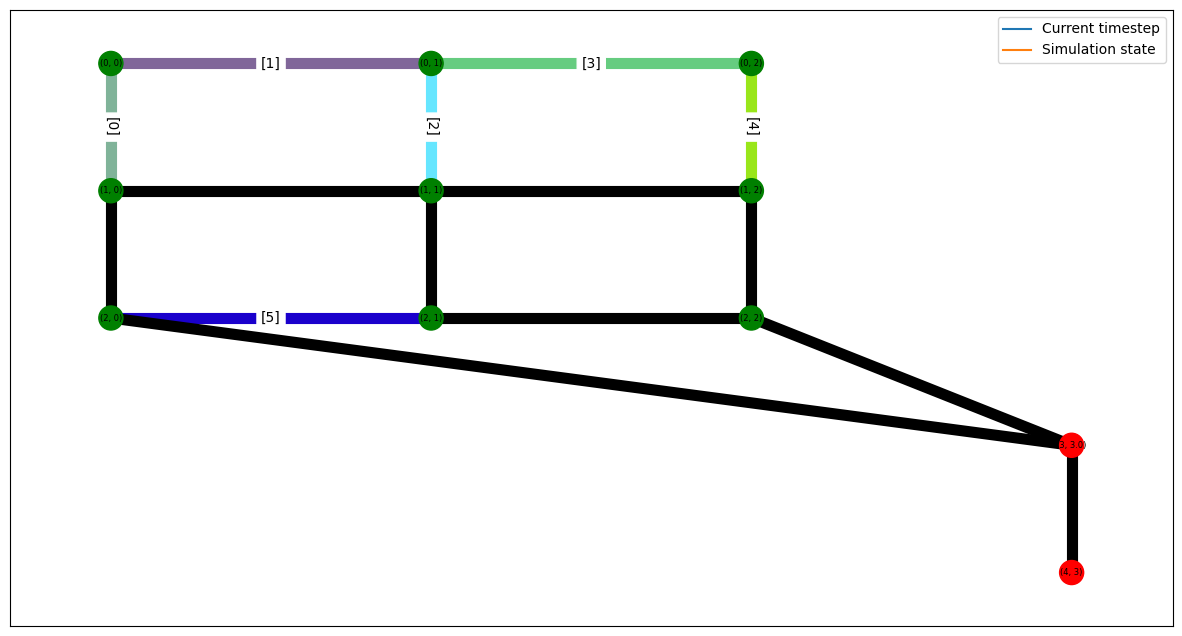

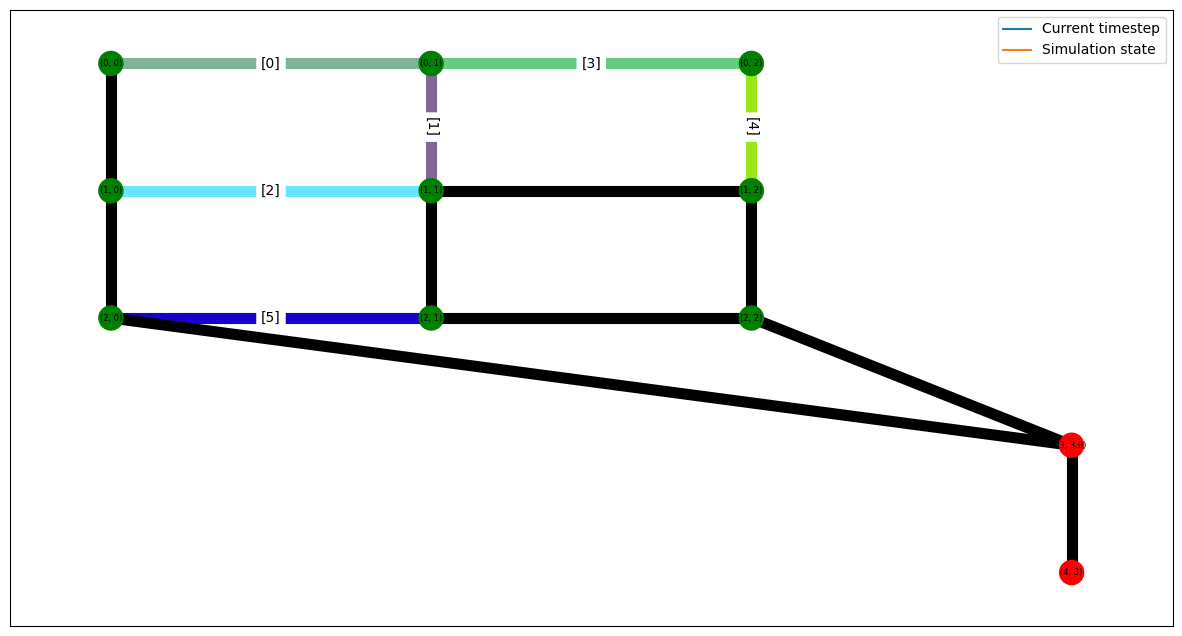

move_list [5, 3, 0]
move len 3


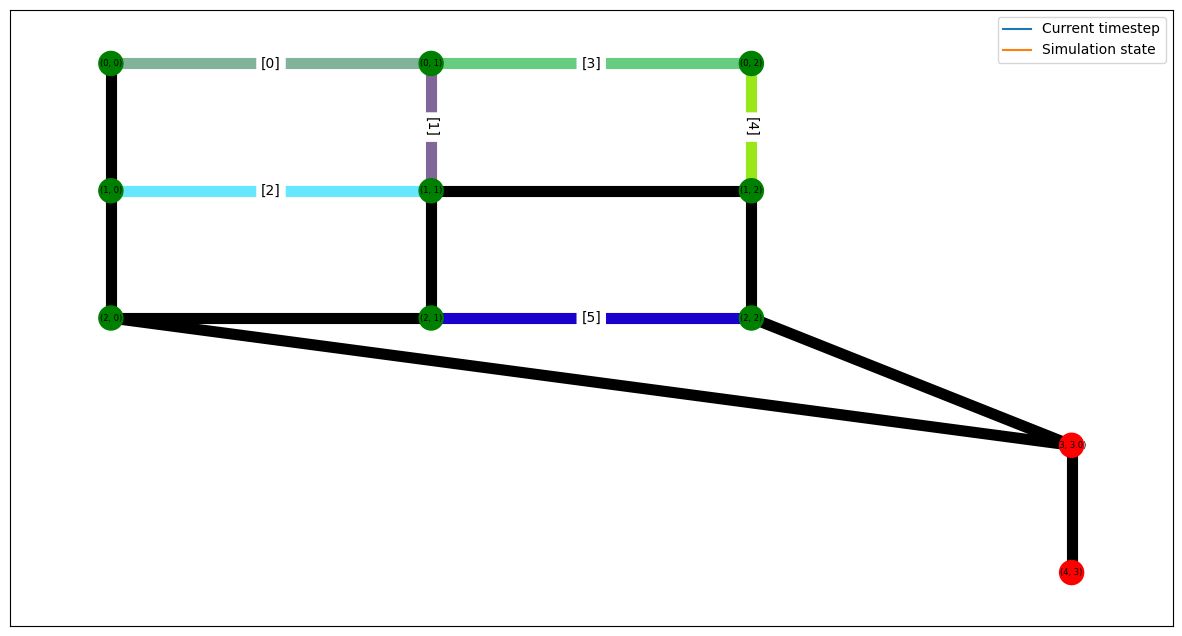

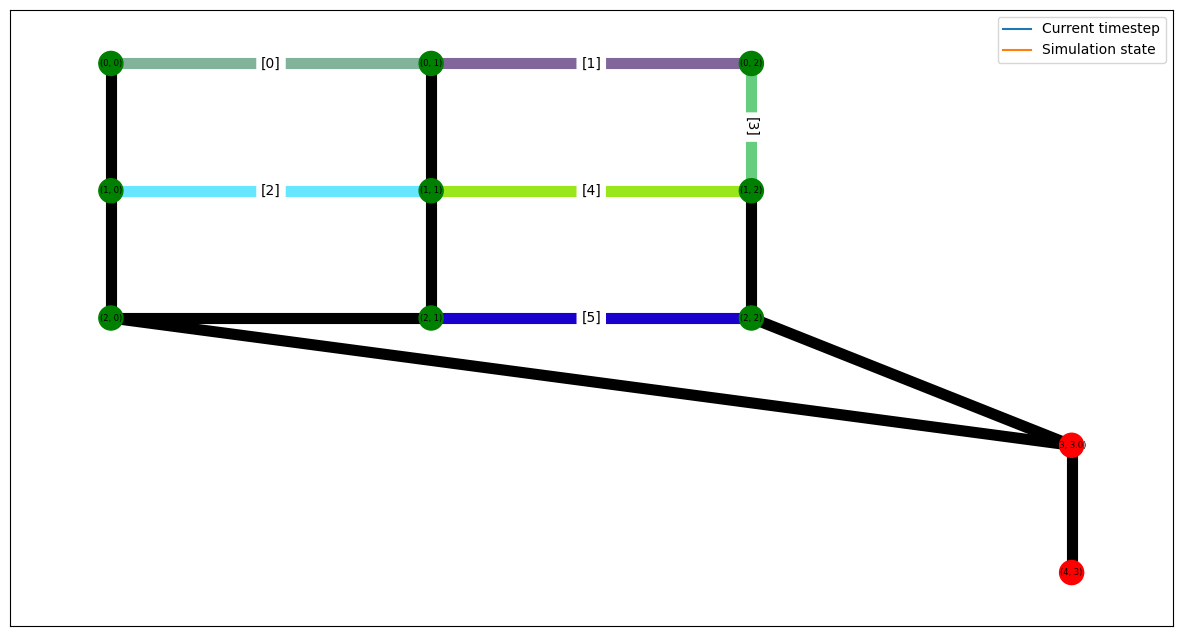

move_list [5, 4, 2, 0]
move len 4


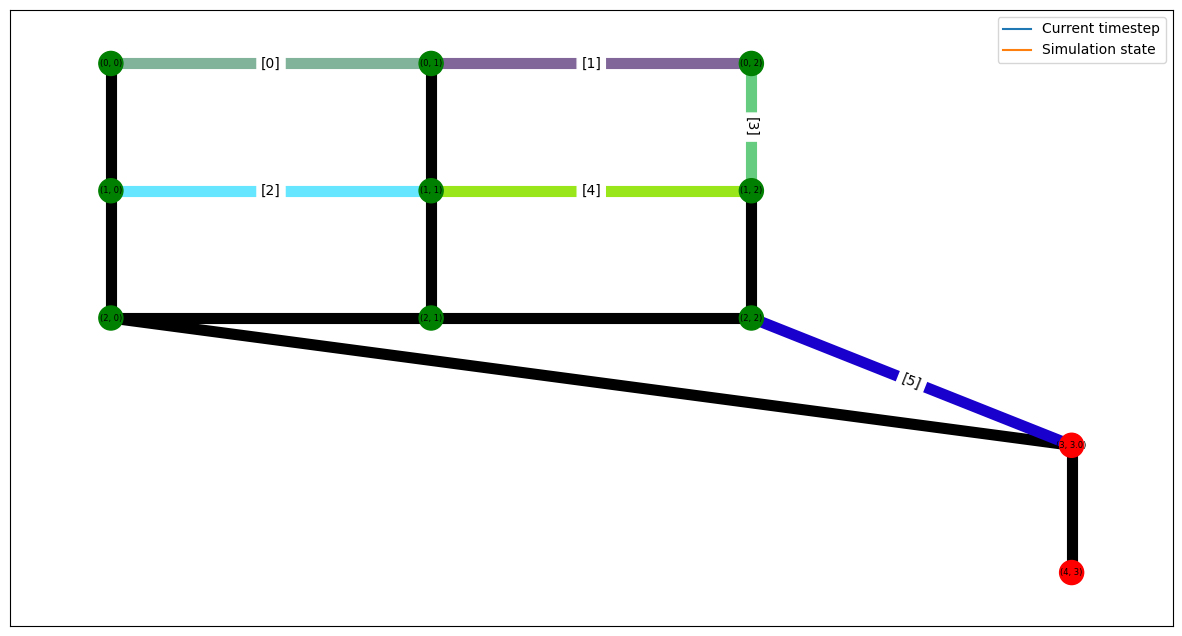

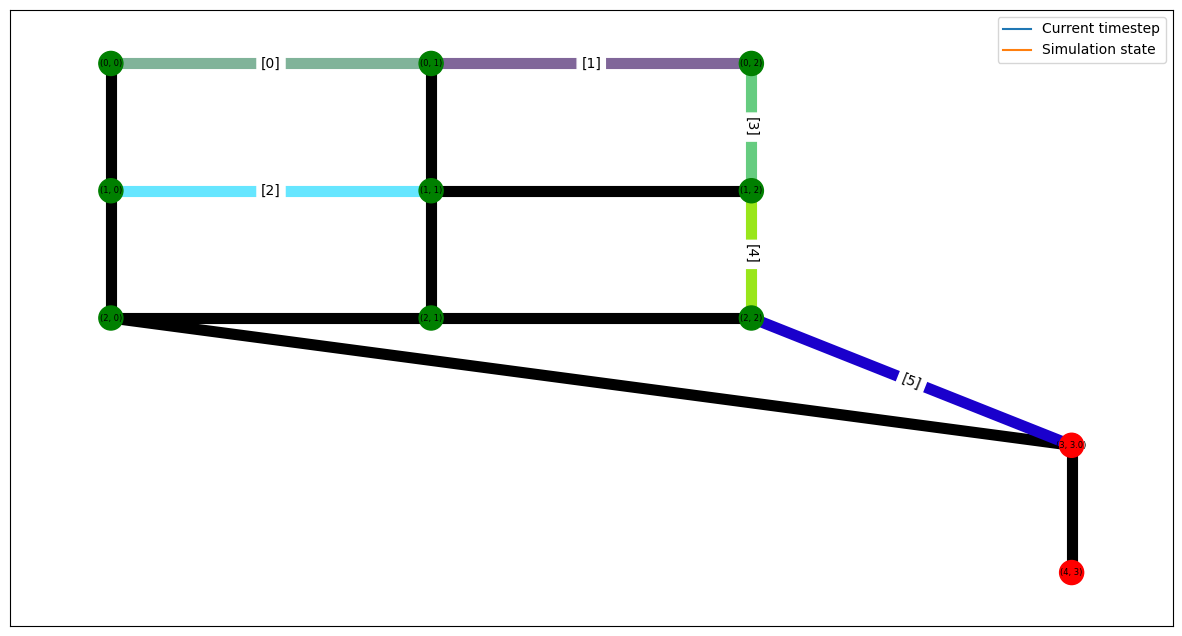

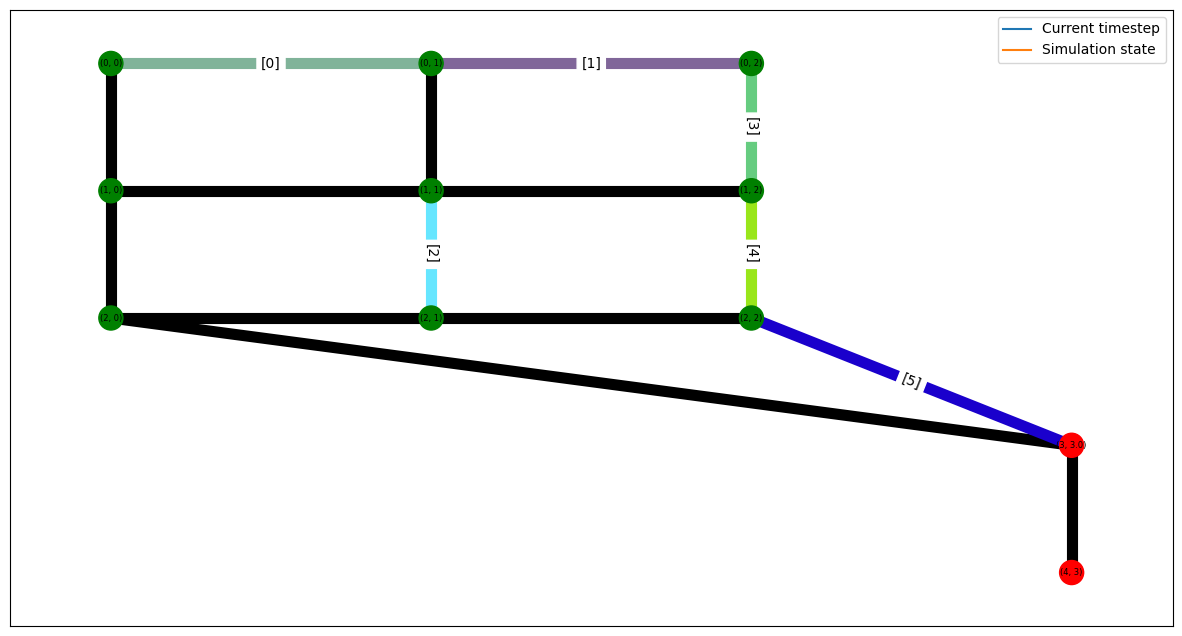

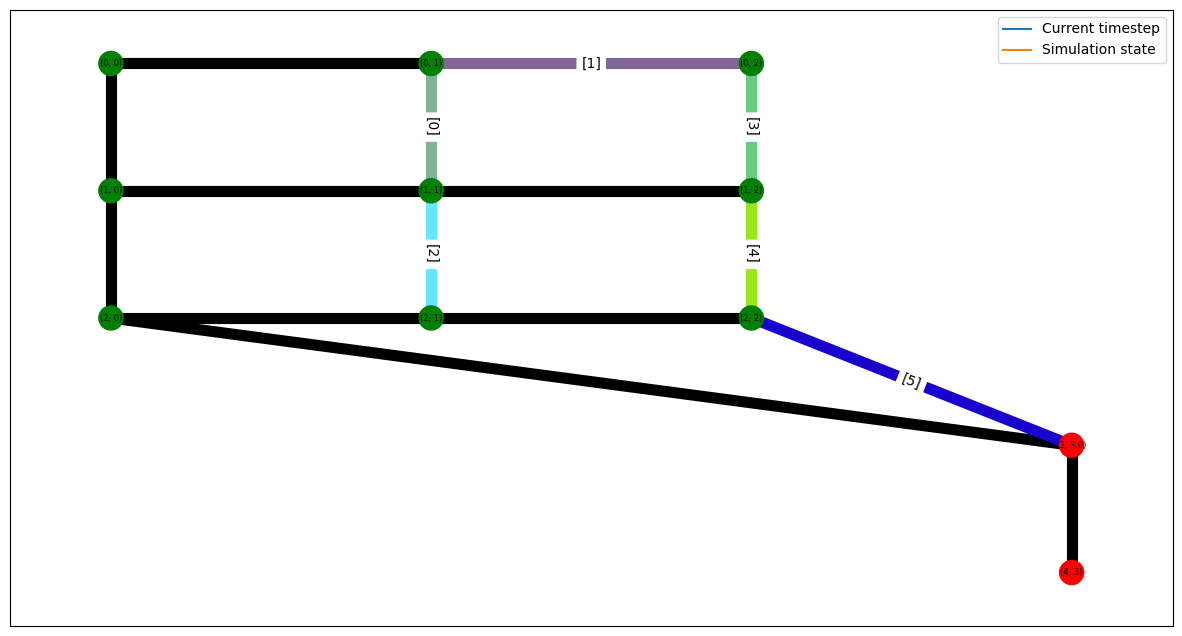

move_list [5, 4, 3, 1]
move len 4


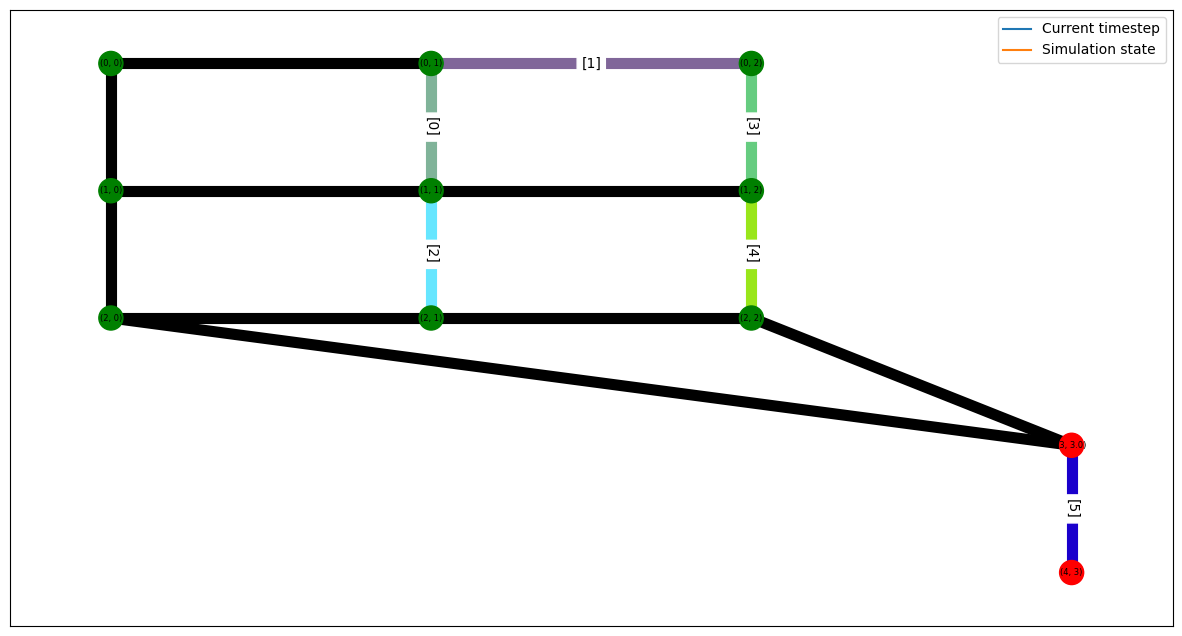

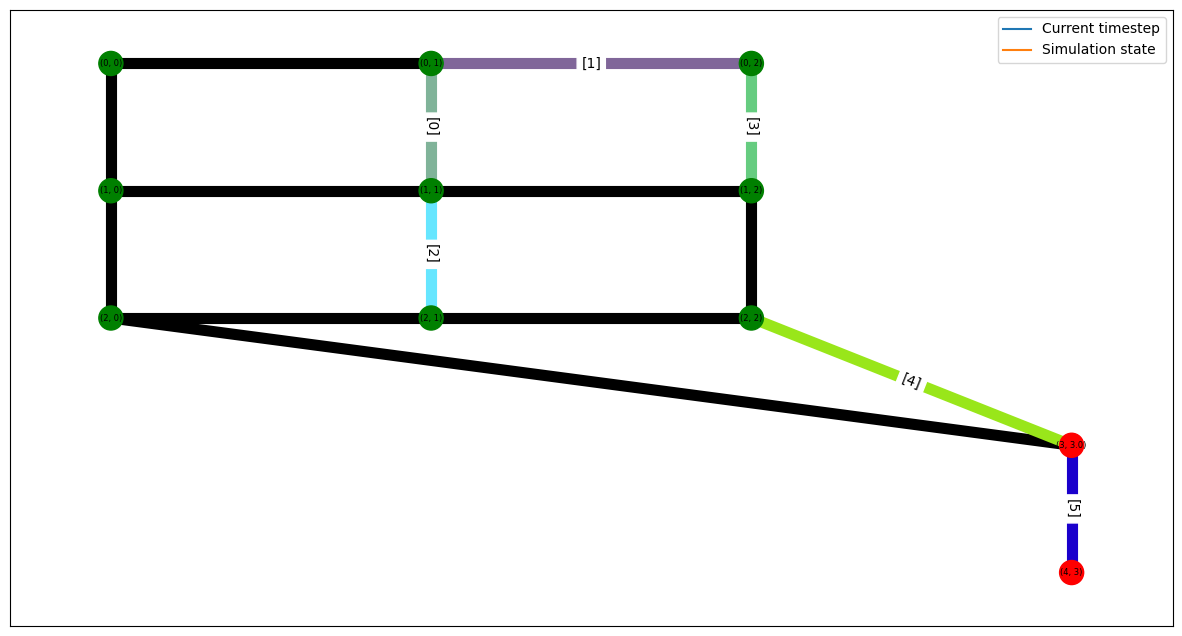

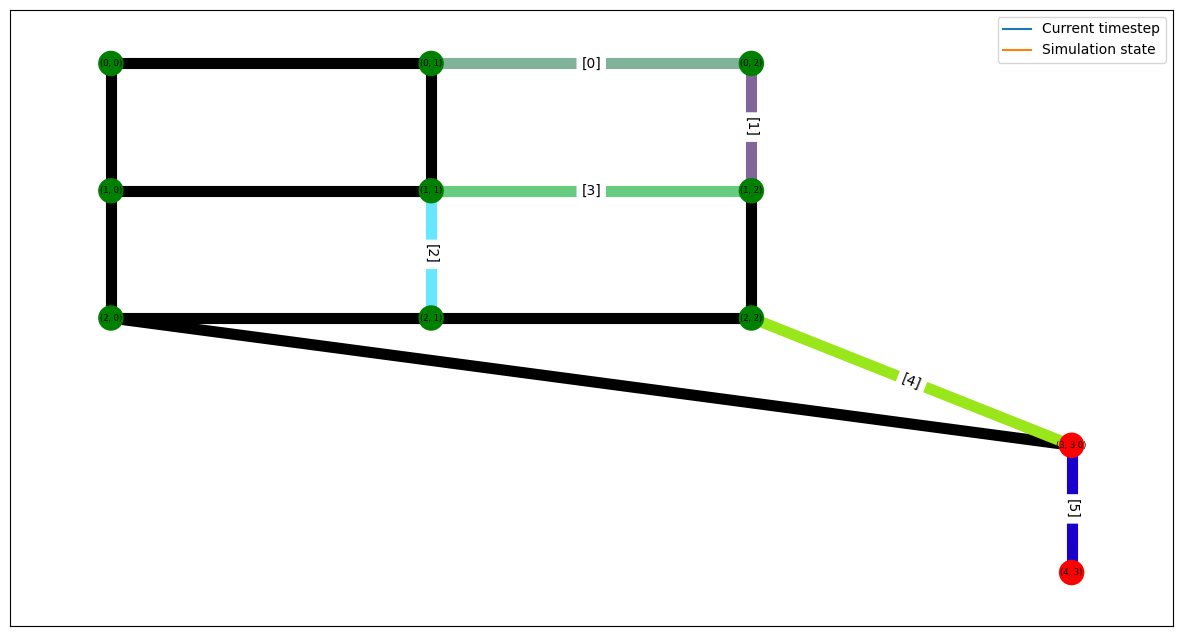


time step: 0, gate (5,) is executed,
move_list [5, 4, 3, 0]
move len 4


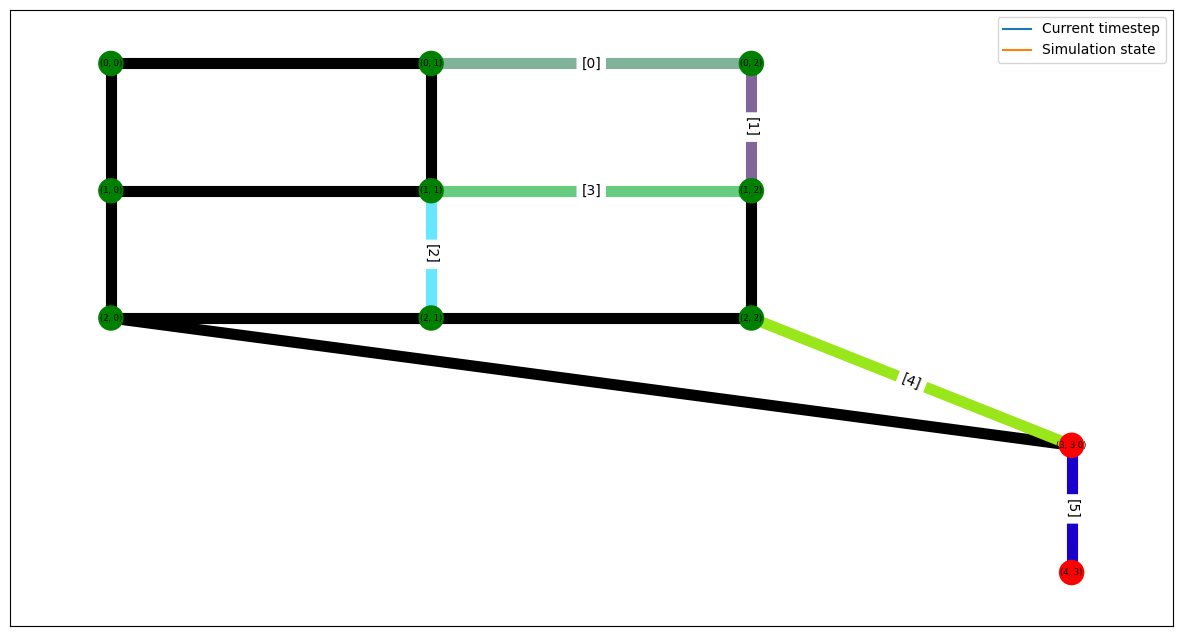

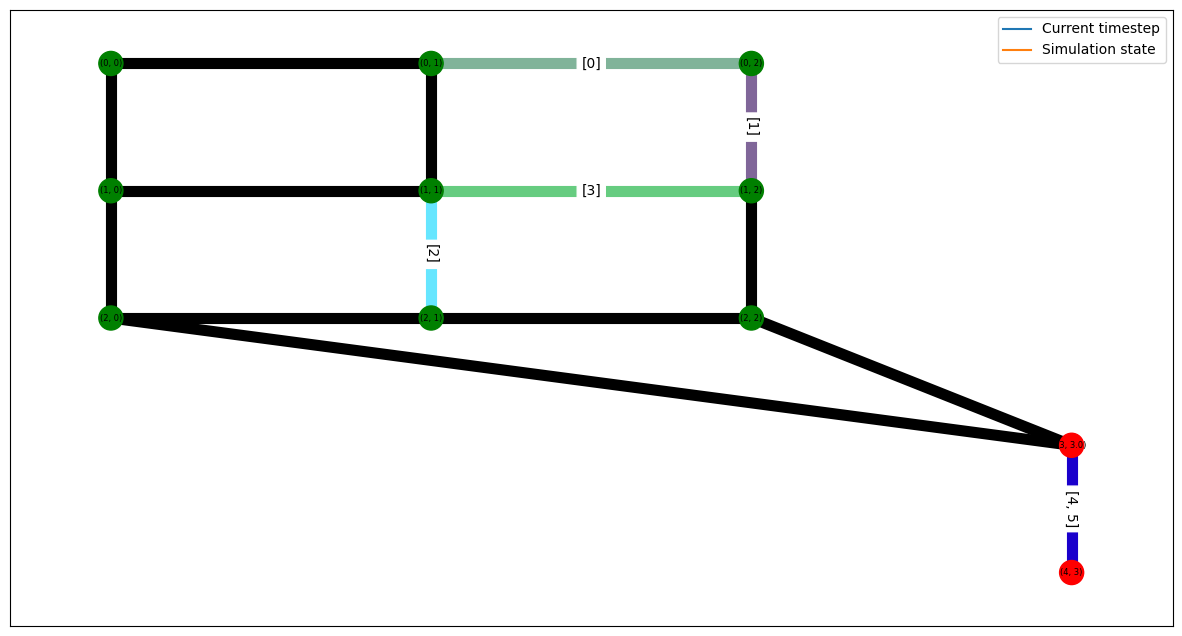

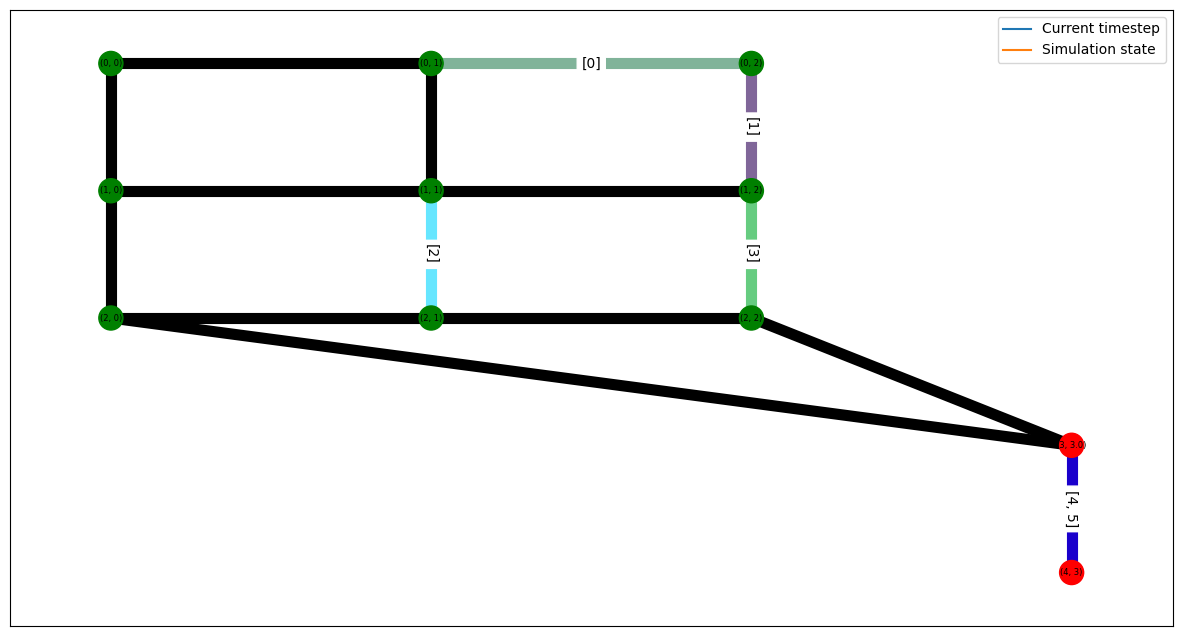


time step: 2, gate (5, 4) is executed,
move_list [5, 3, 2, 0]
move len 4


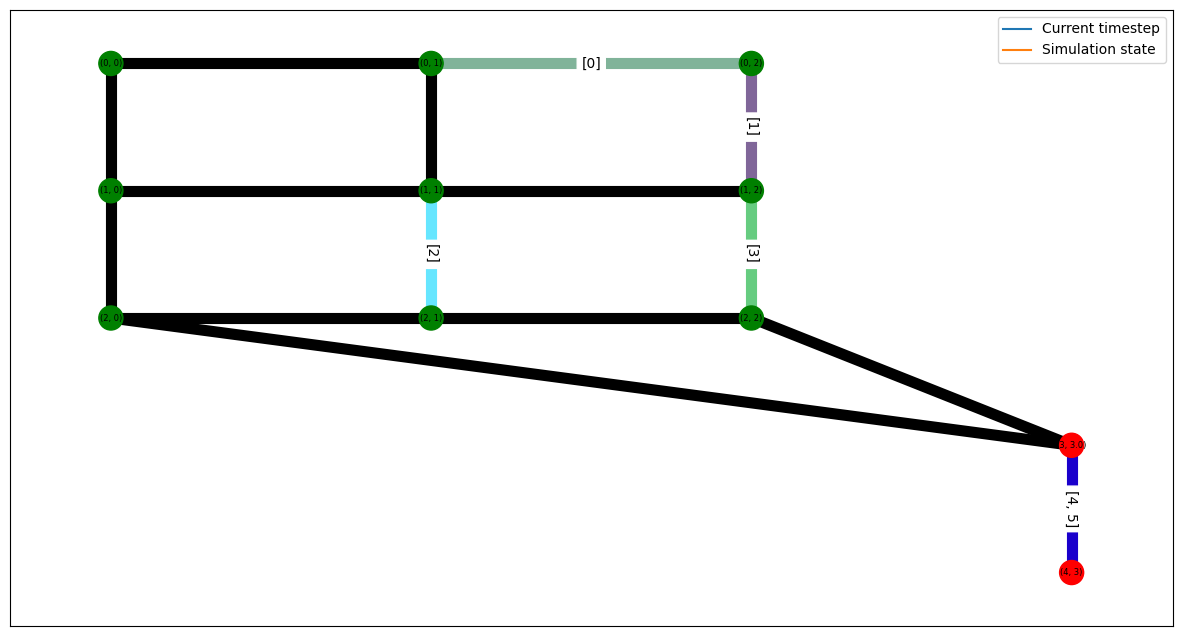

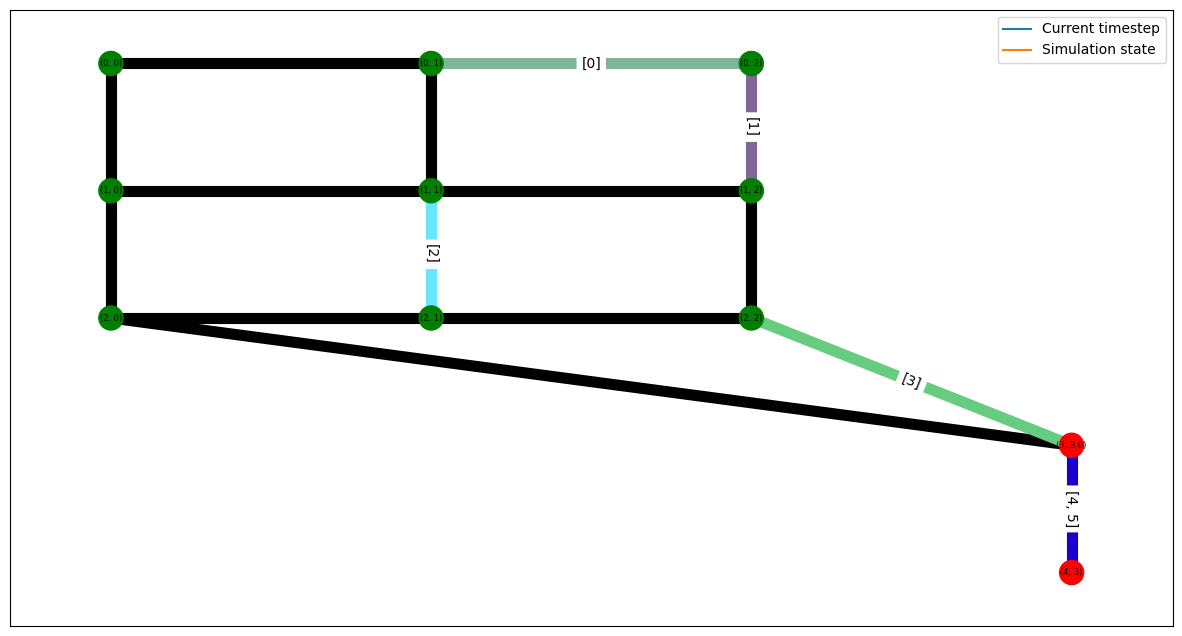

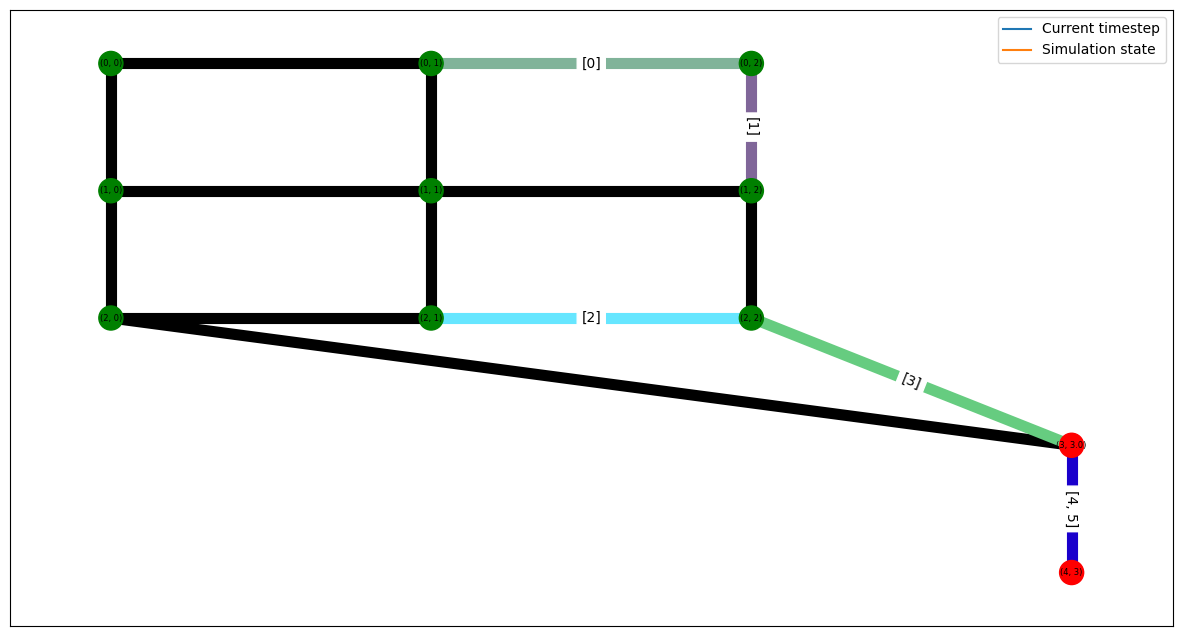

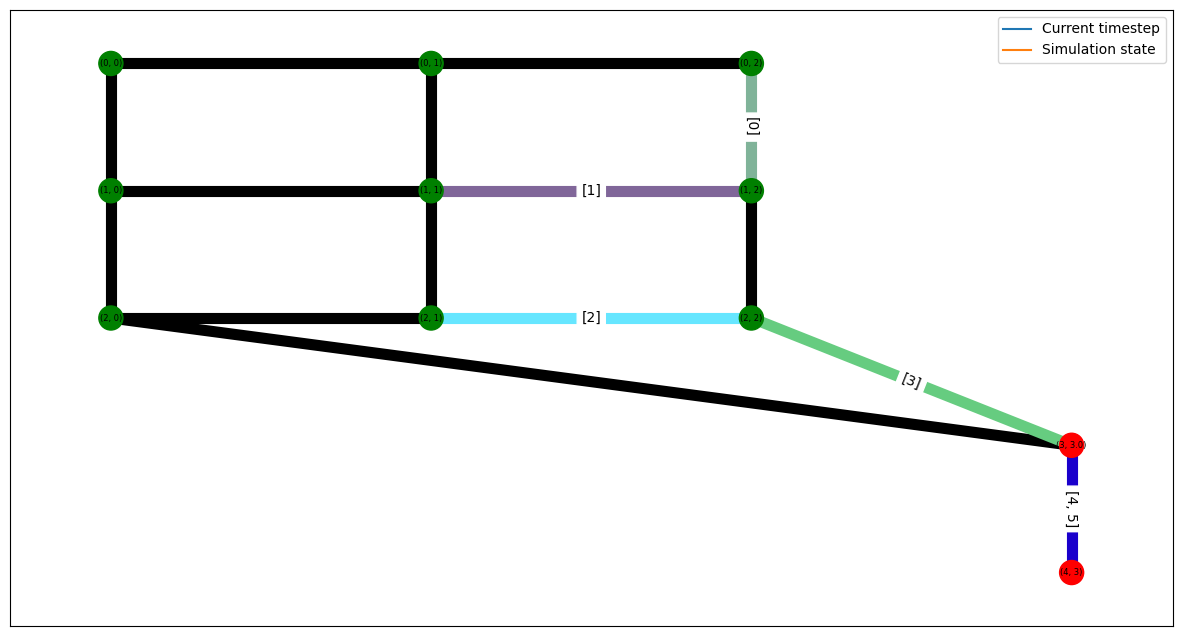


time step: 2, gate (5, 4) is executed,
move_list [5, 3, 2, 1]
move len 4


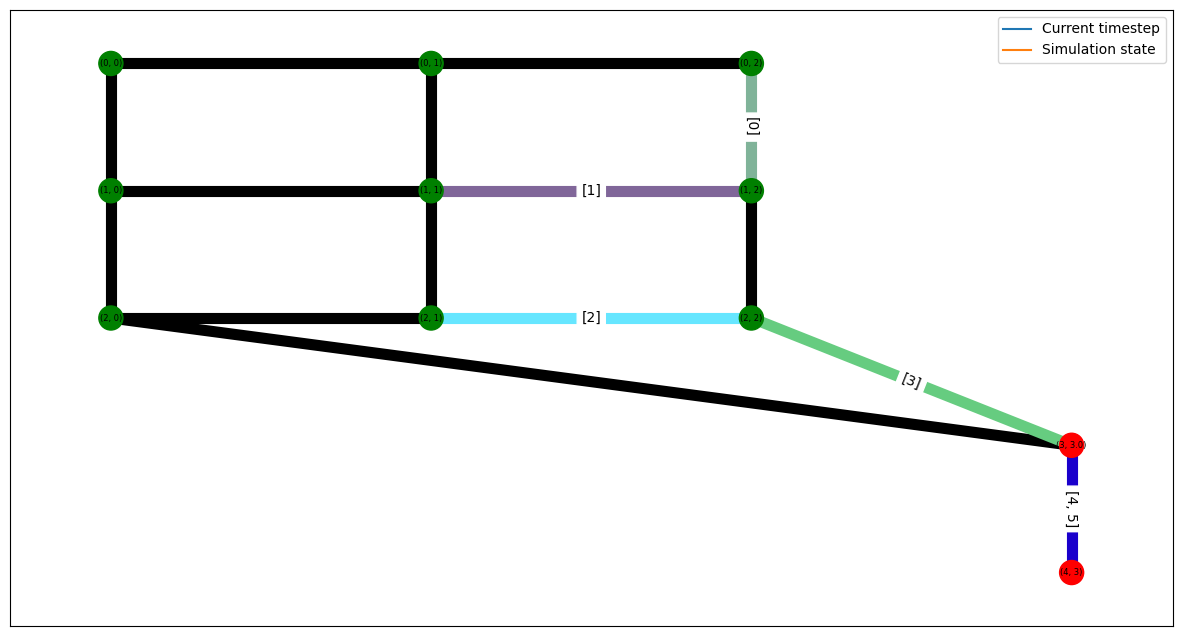

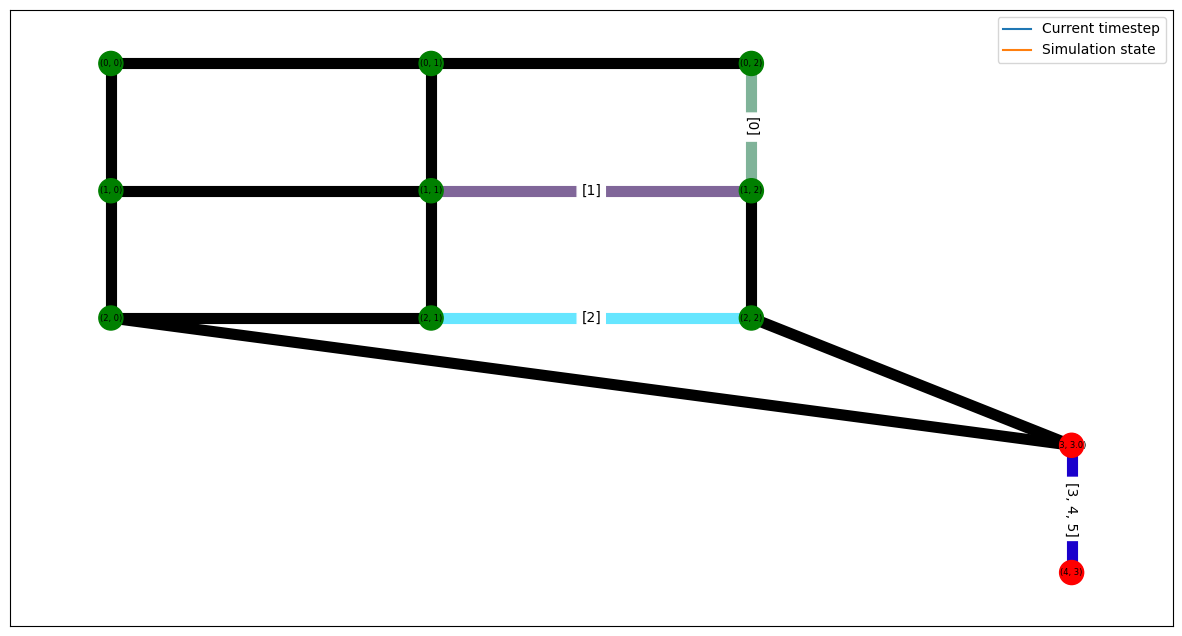

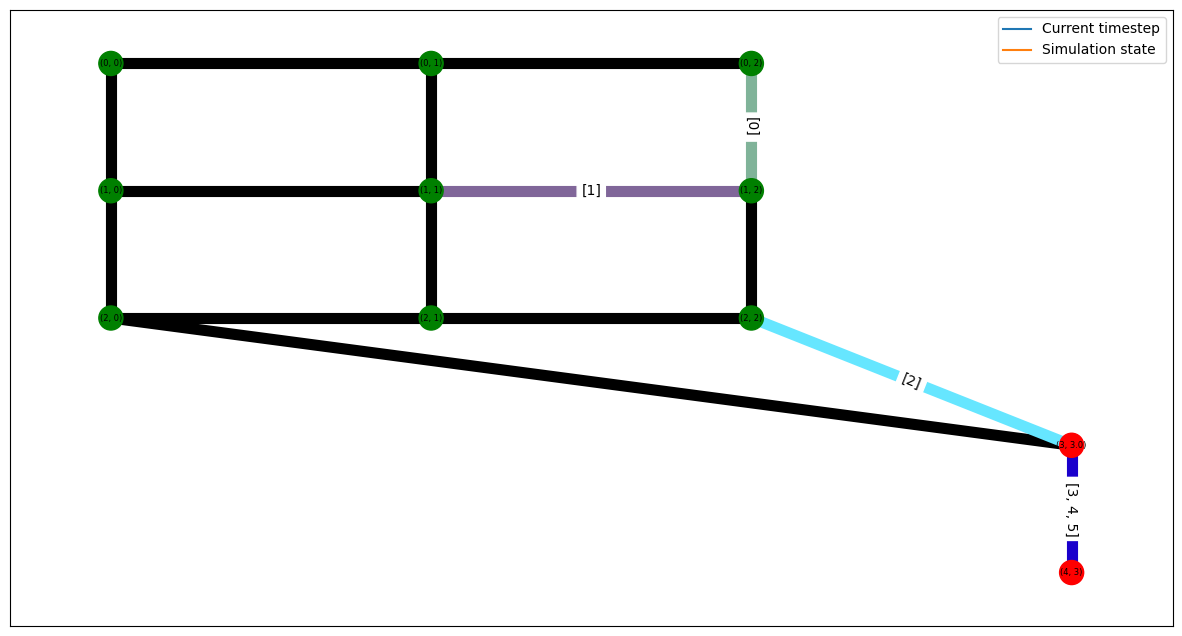

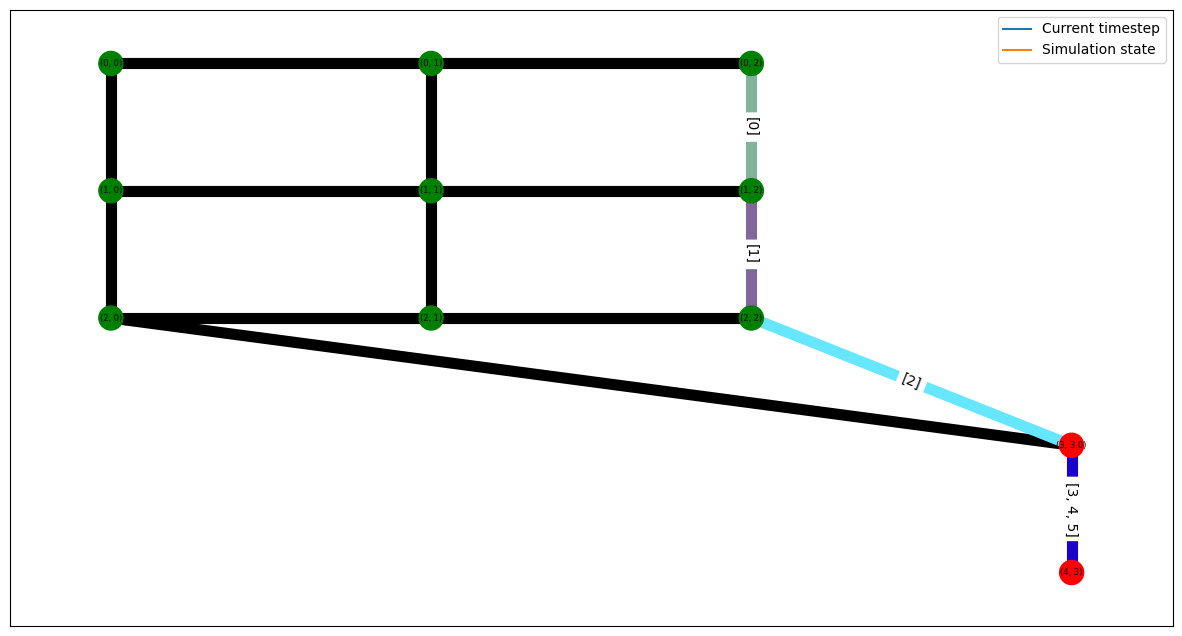


time step: 2, gate (5, 4) is executed,
move_list [4, 2, 1, 0]
move len 4


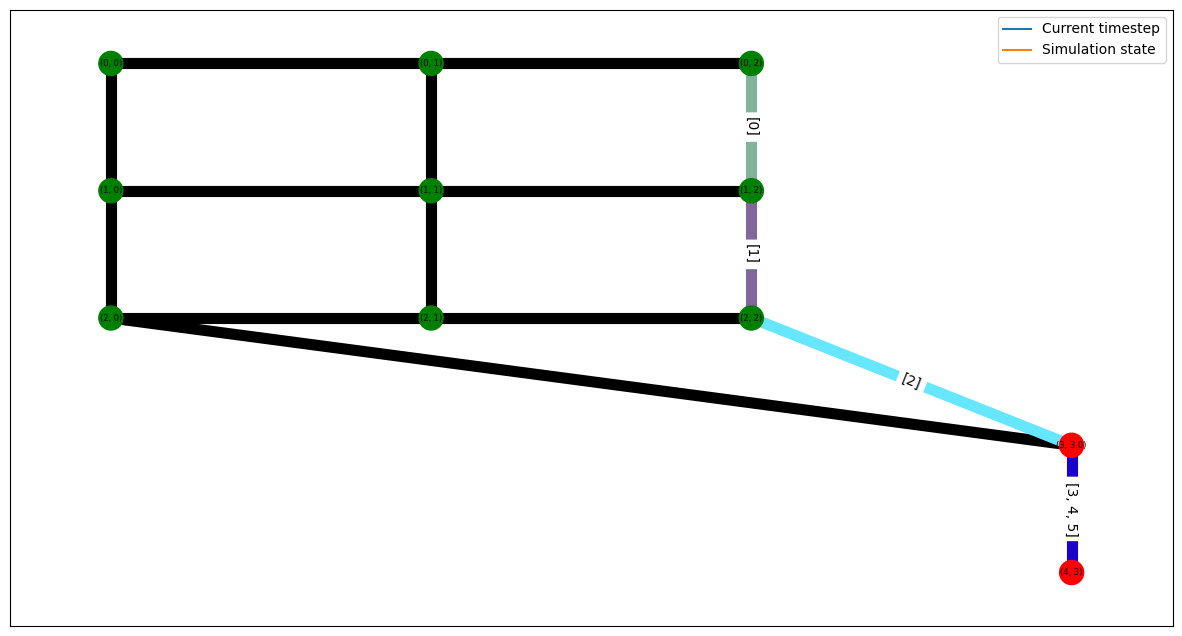

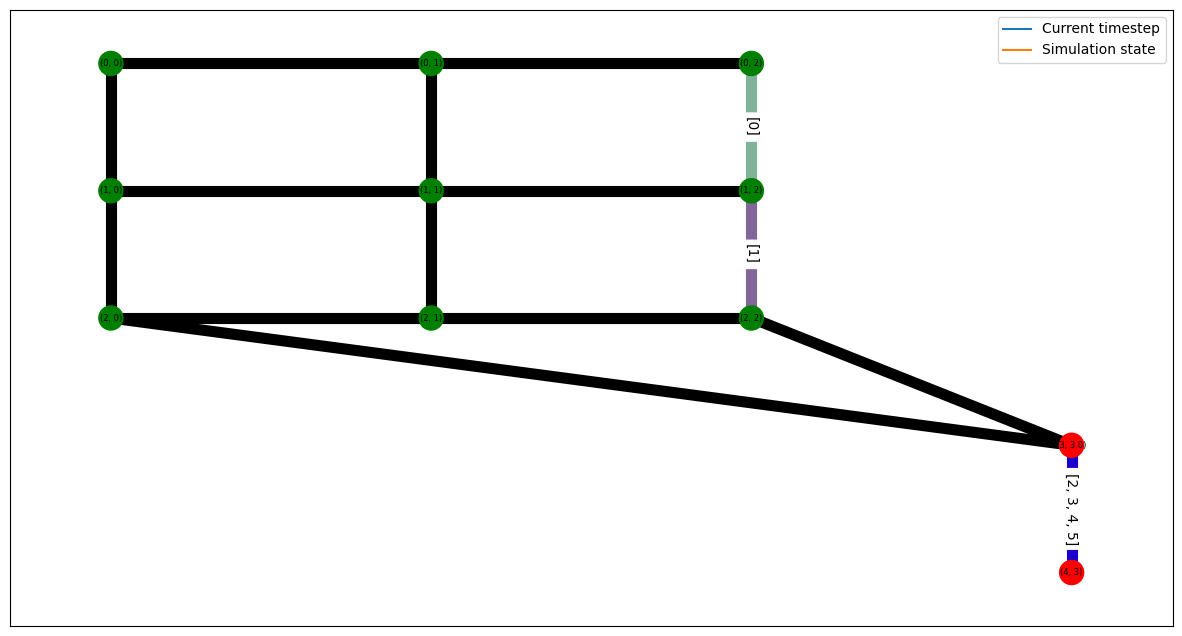

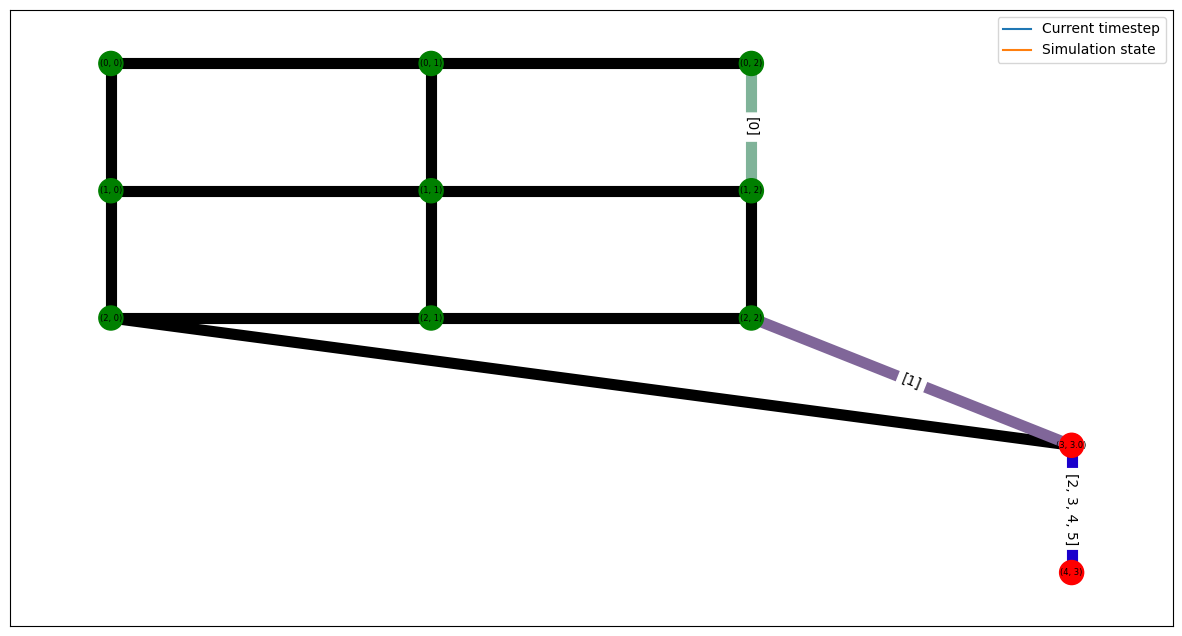


time step: 6, gate (4,) is executed,
move_list [5, 1, 0]
move len 3


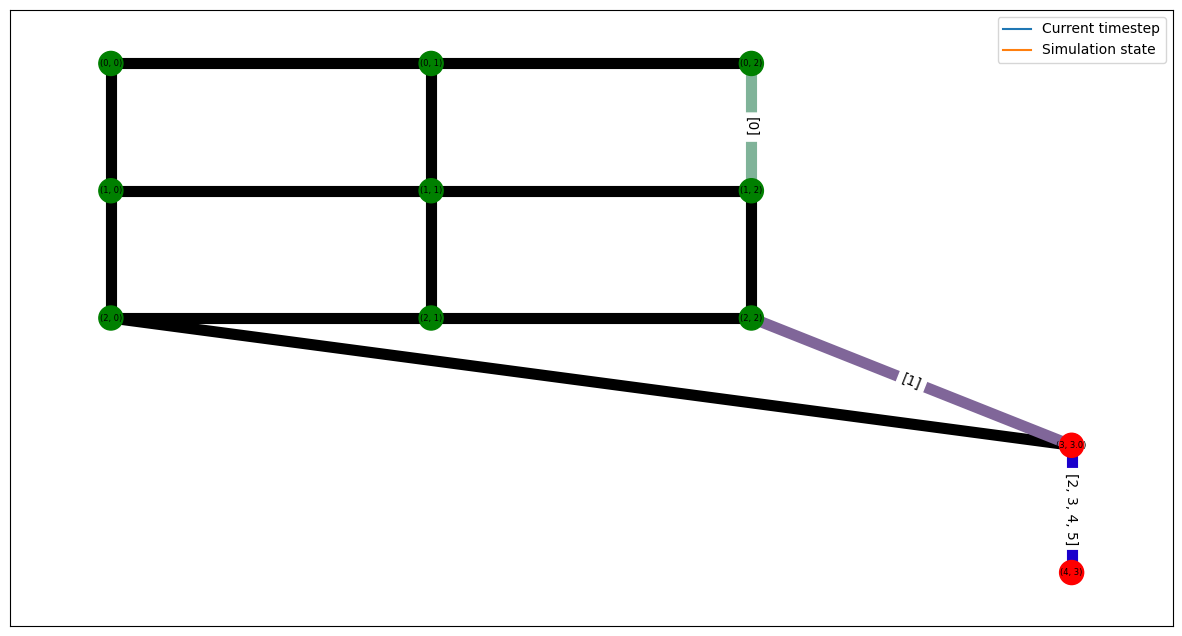

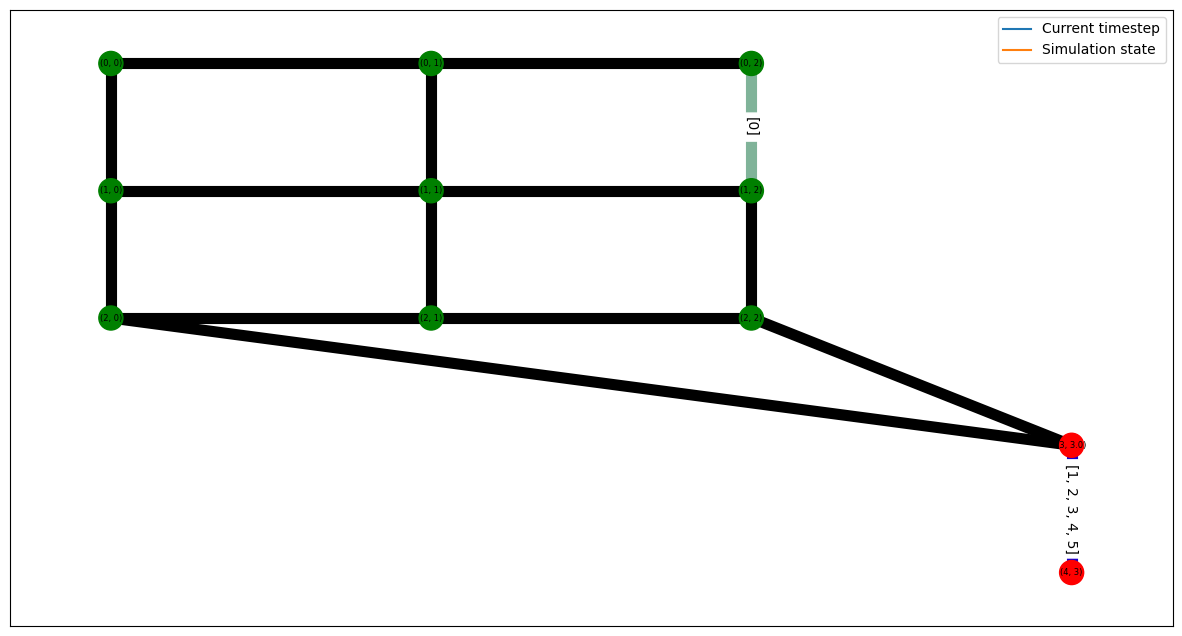

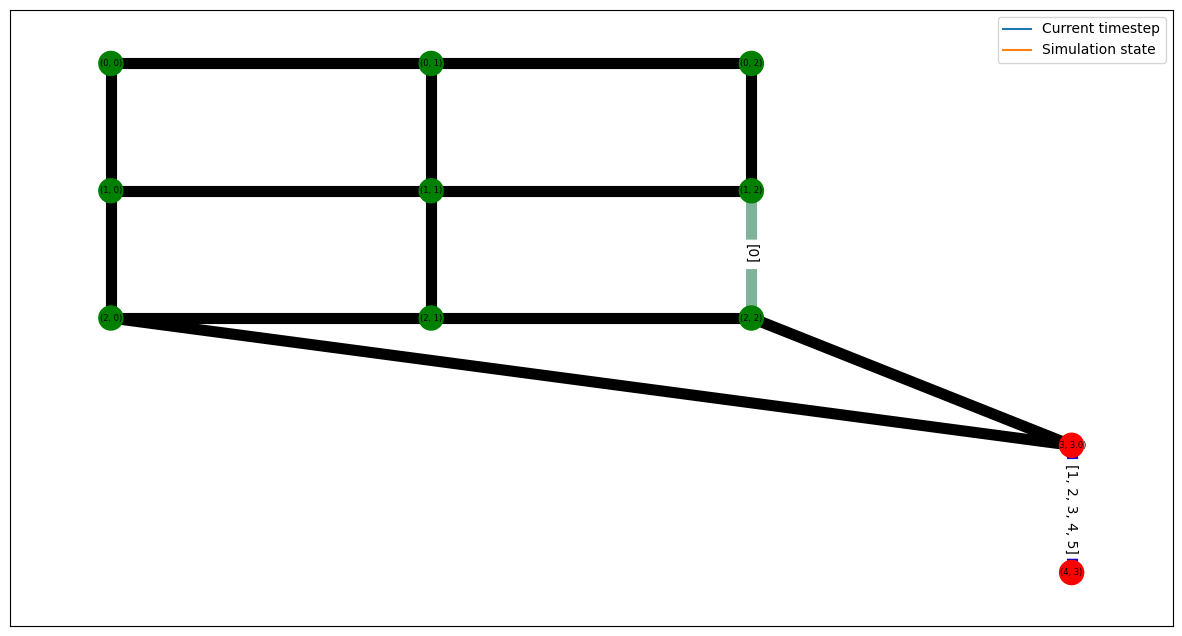


time step: 8, gate (5, 3) is executed,
move_list [5, 0]
move len 2


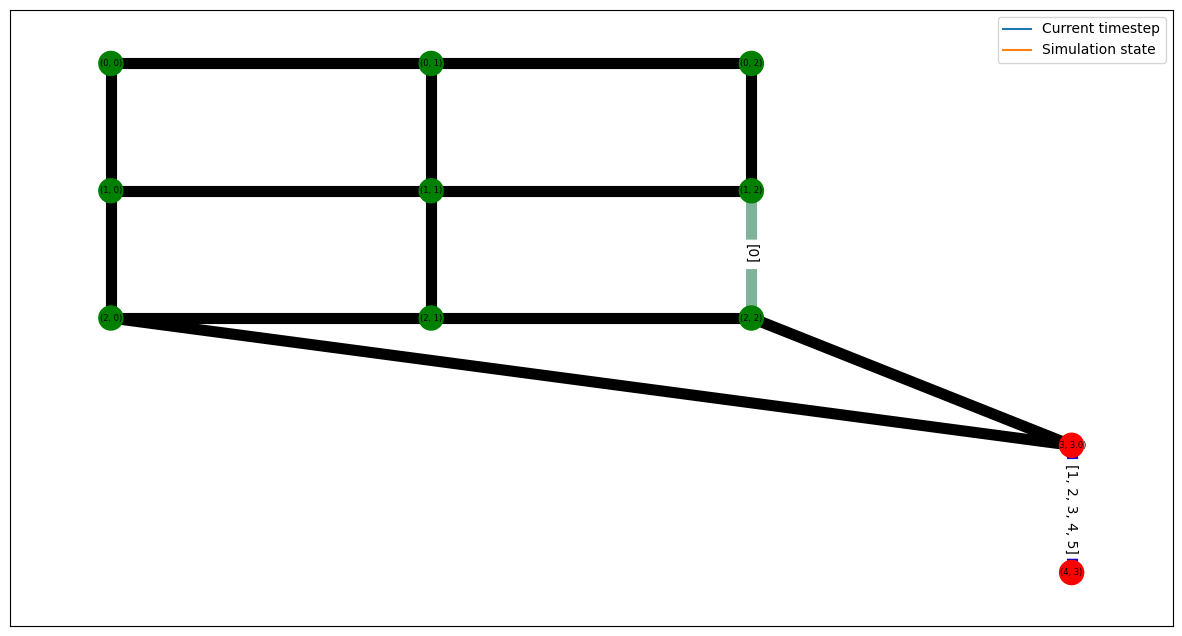

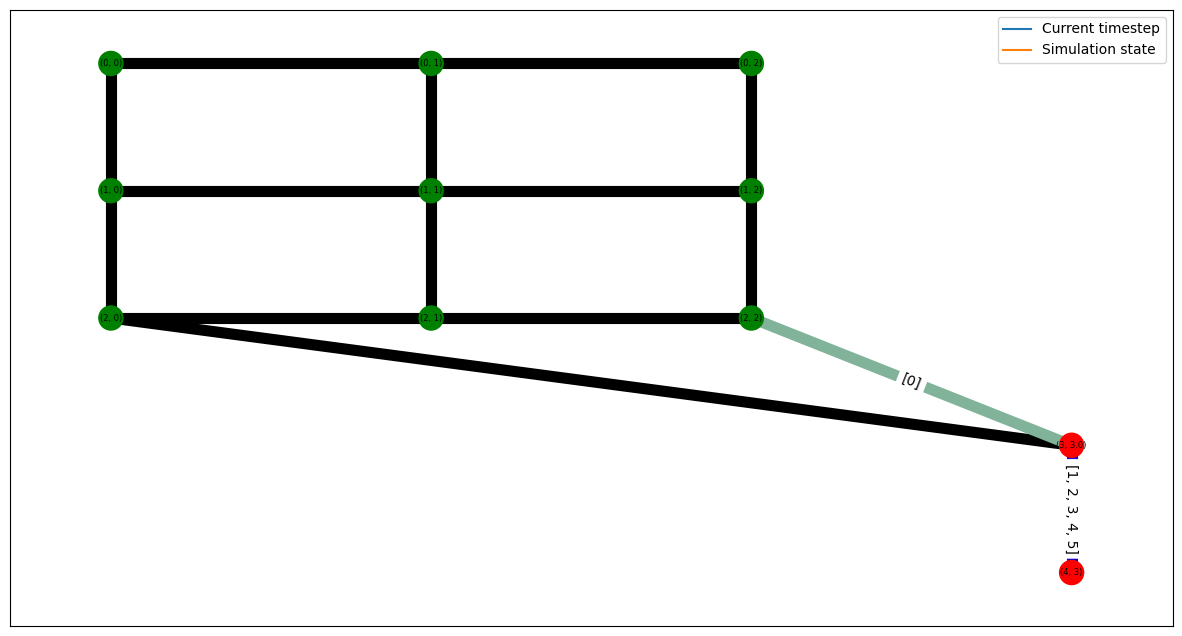


time step: 8, gate (5, 3) is executed,
move_list [5, 0]
move len 2


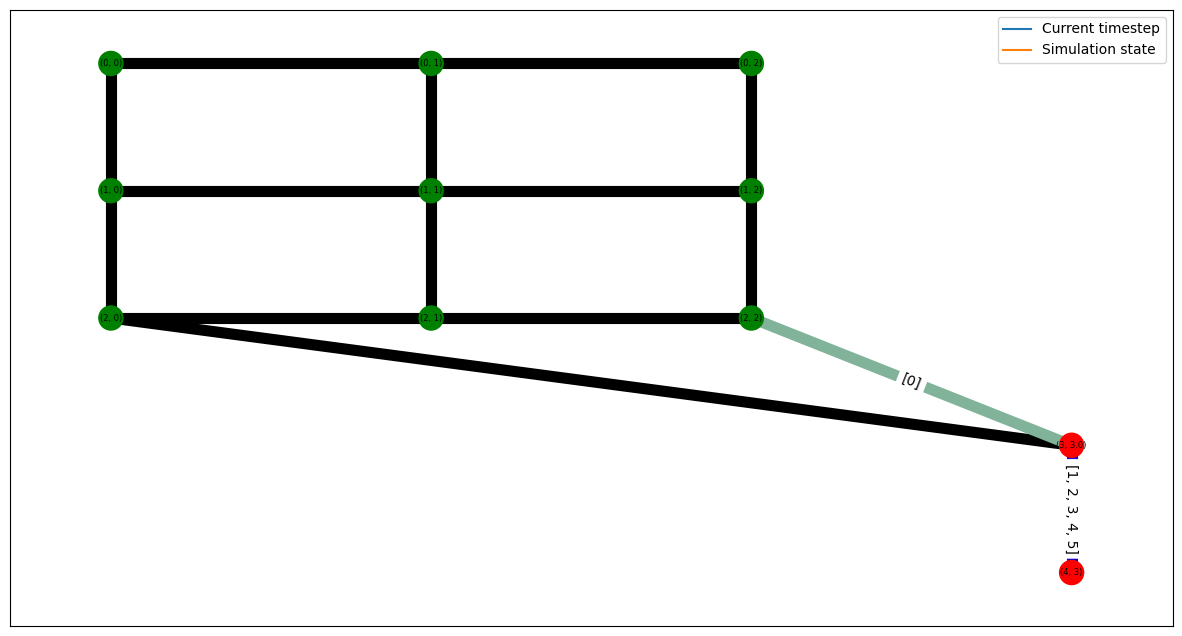

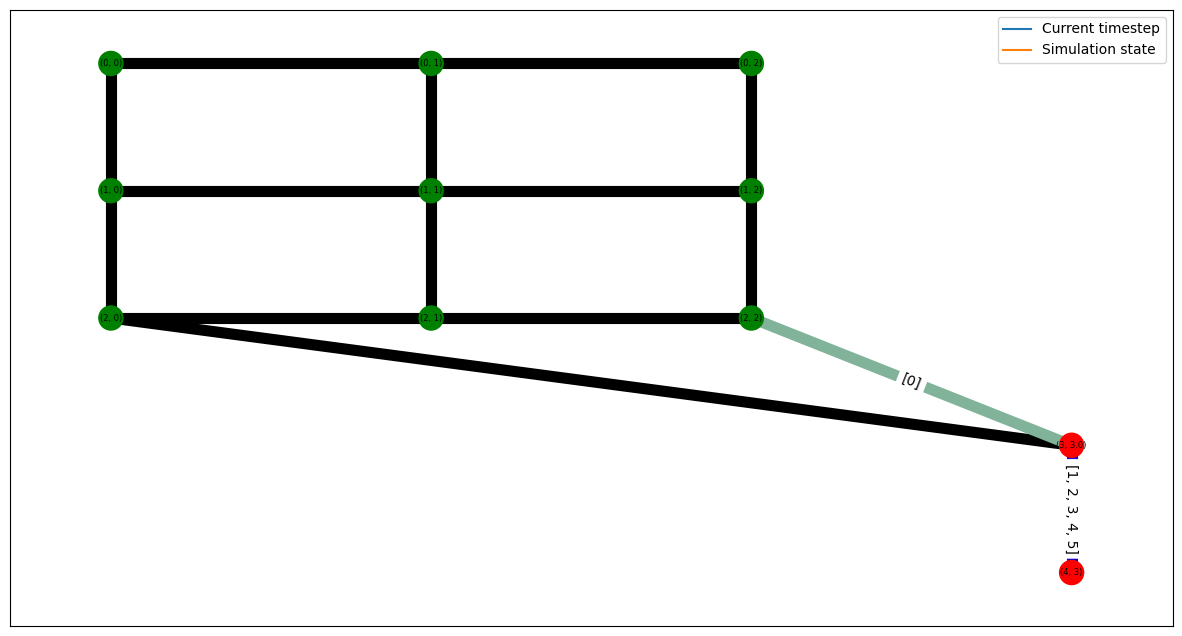


time step: 8, gate (5, 3) is executed,
move_list [4, 0]
move len 2


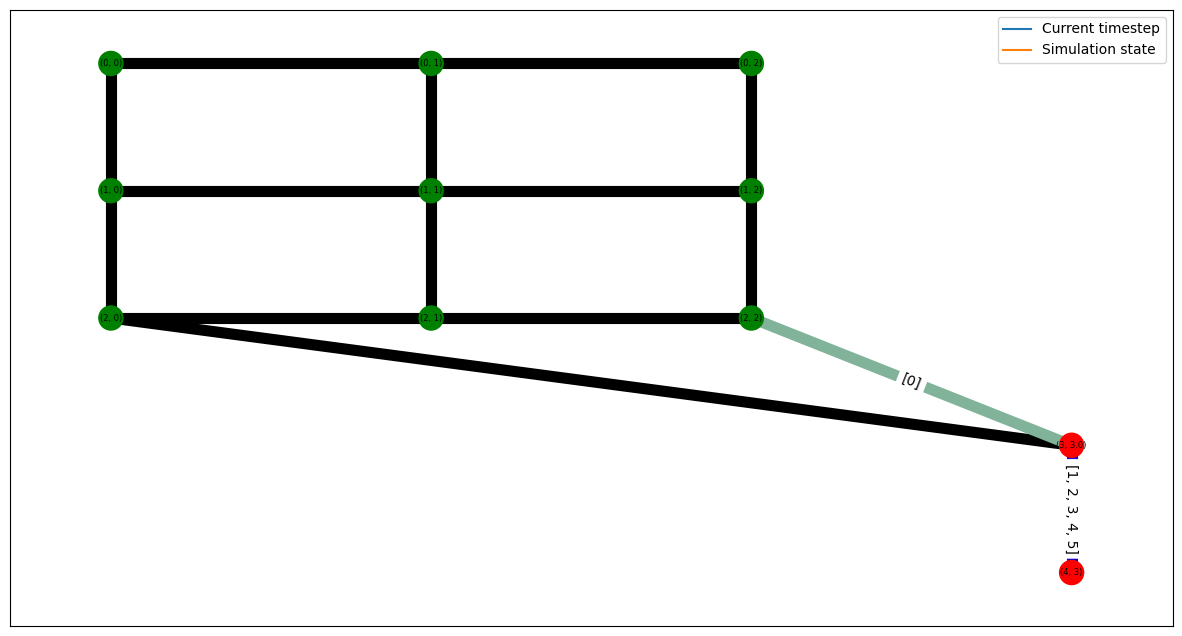

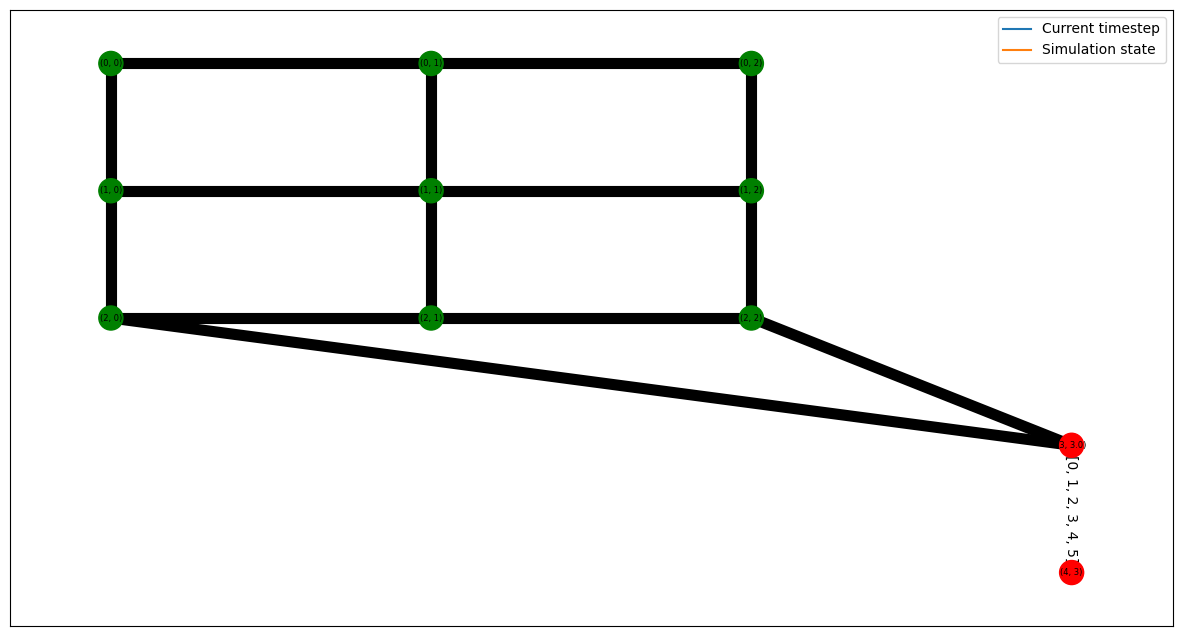


time step: 12, gate (4, 3) is executed,
move_list [4]
move len 1


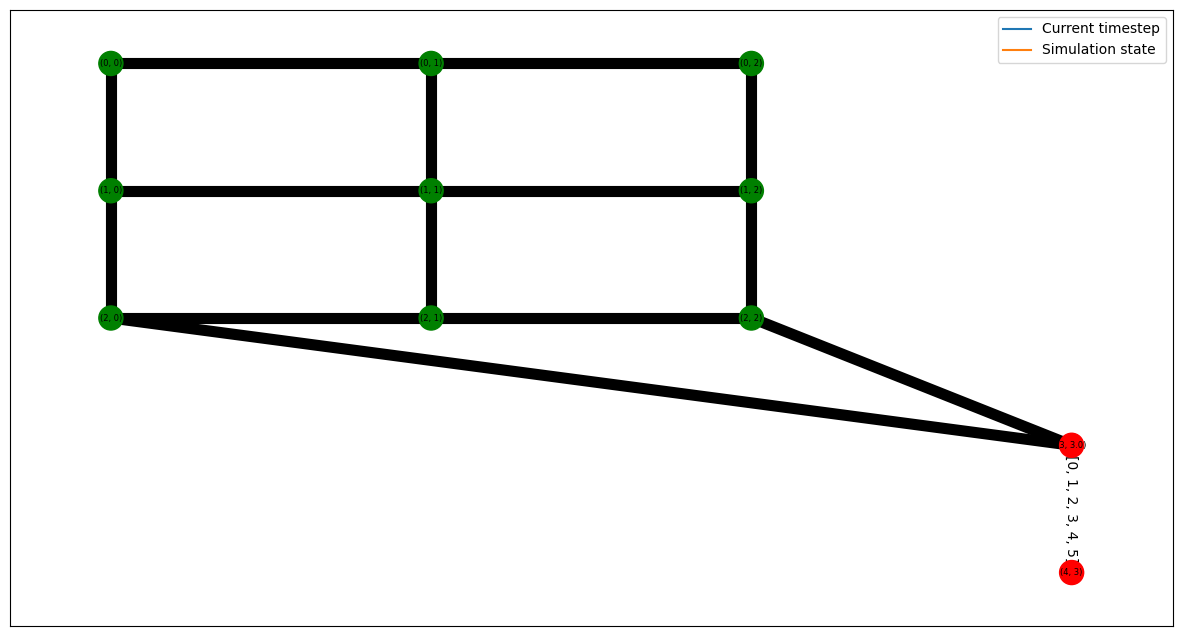


time step: 12, gate (4, 3) is executed,
move_list [4]
move len 1


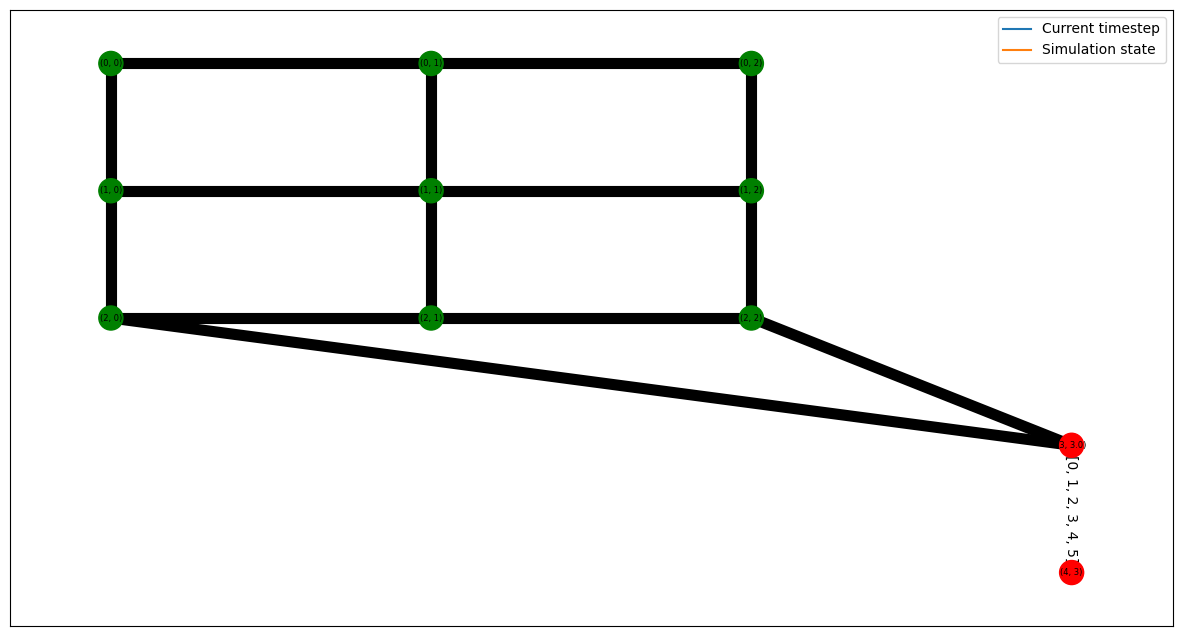


time step: 12, gate (4, 3) is executed,
move_list [5]
move len 1


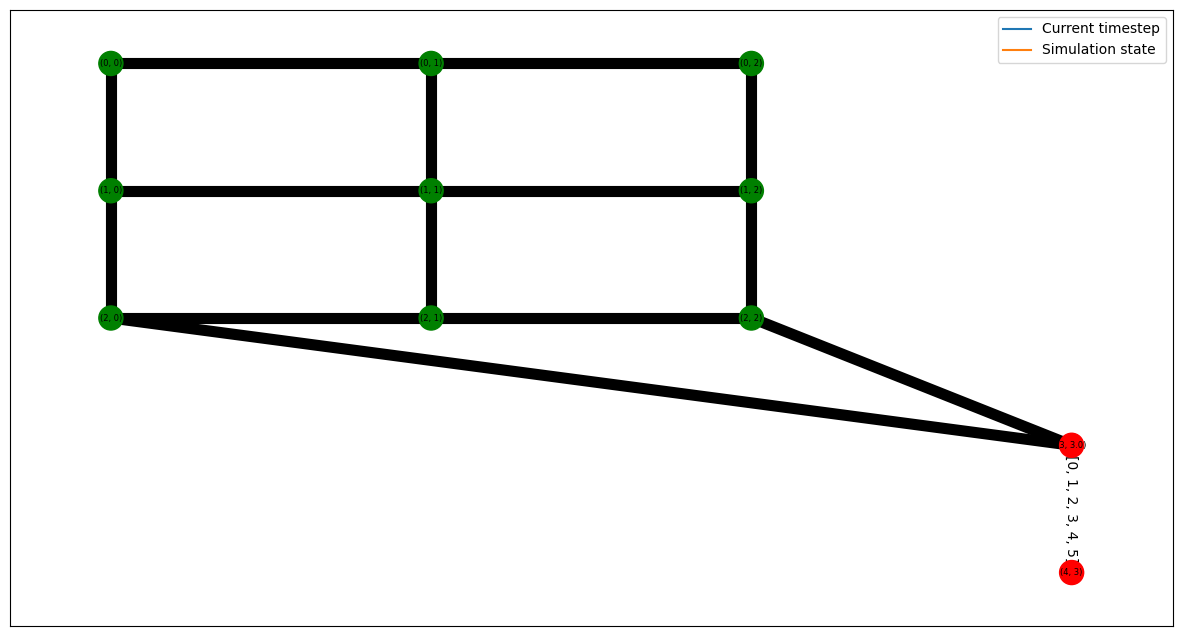


time step: 16, gate (5, 2) is executed,
move_list [5]
move len 1


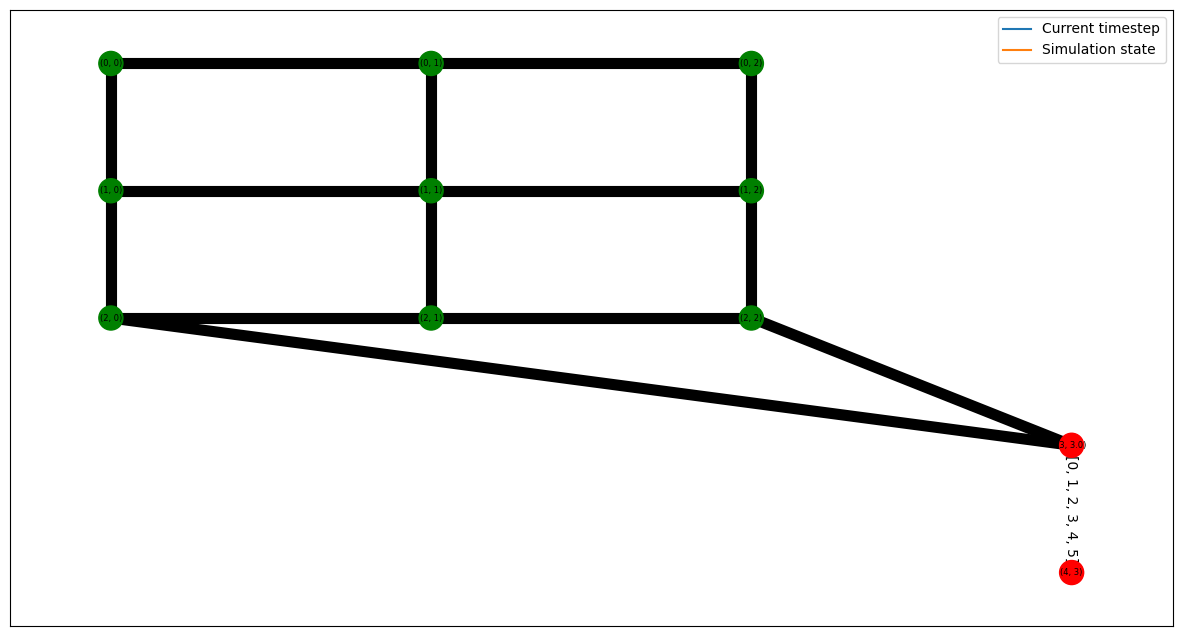


time step: 16, gate (5, 2) is executed,
move_list [5]
move len 1


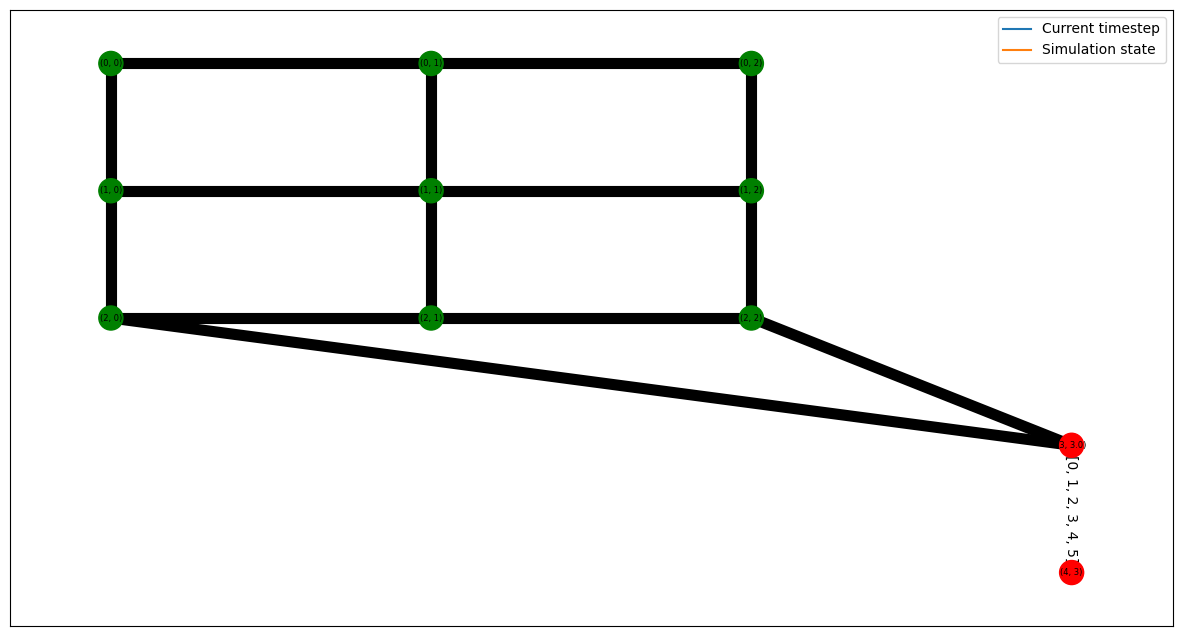


time step: 16, gate (5, 2) is executed,
move_list [4]
move len 1


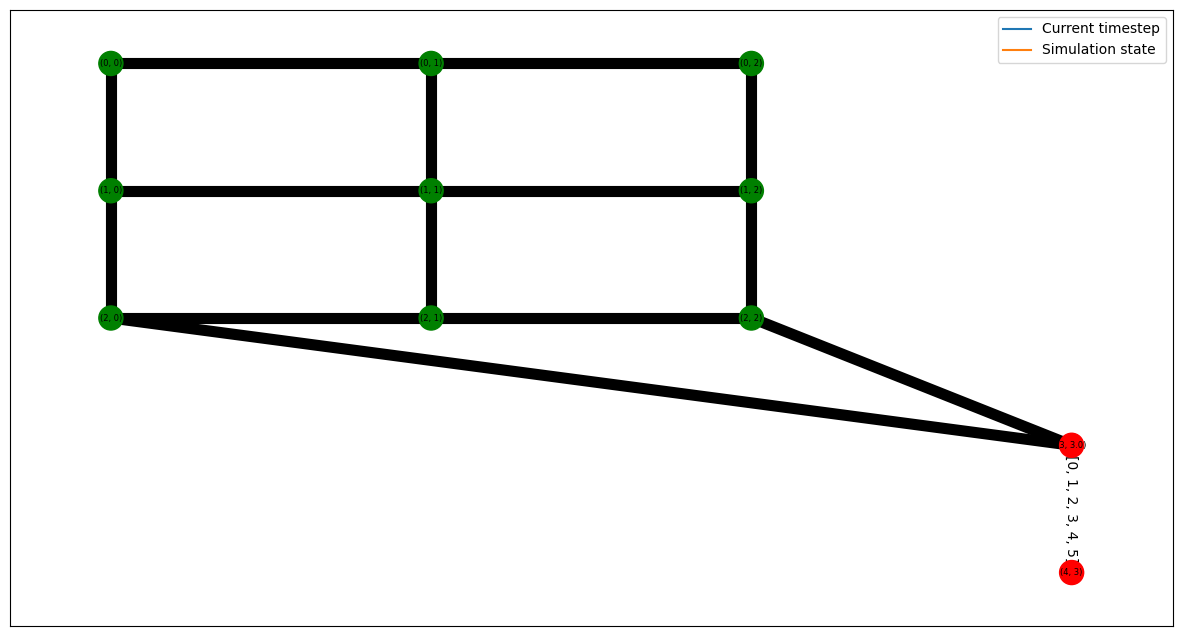


time step: 20, gate (4, 2) is executed,
move_list [4]
move len 1


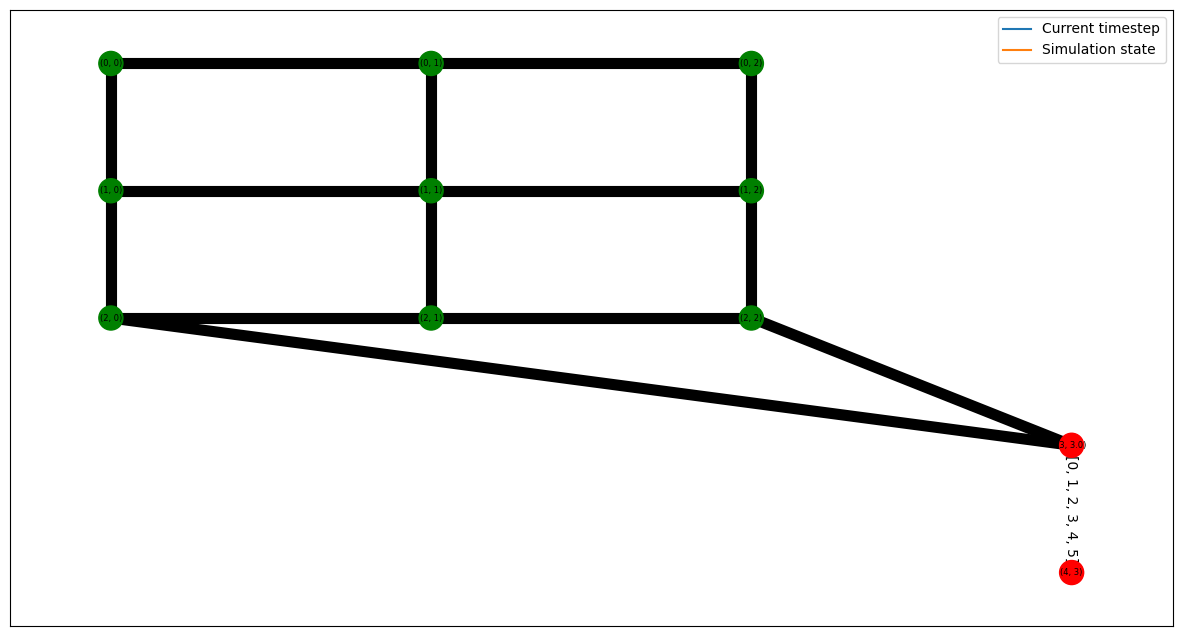


time step: 20, gate (4, 2) is executed,
move_list [4]
move len 1


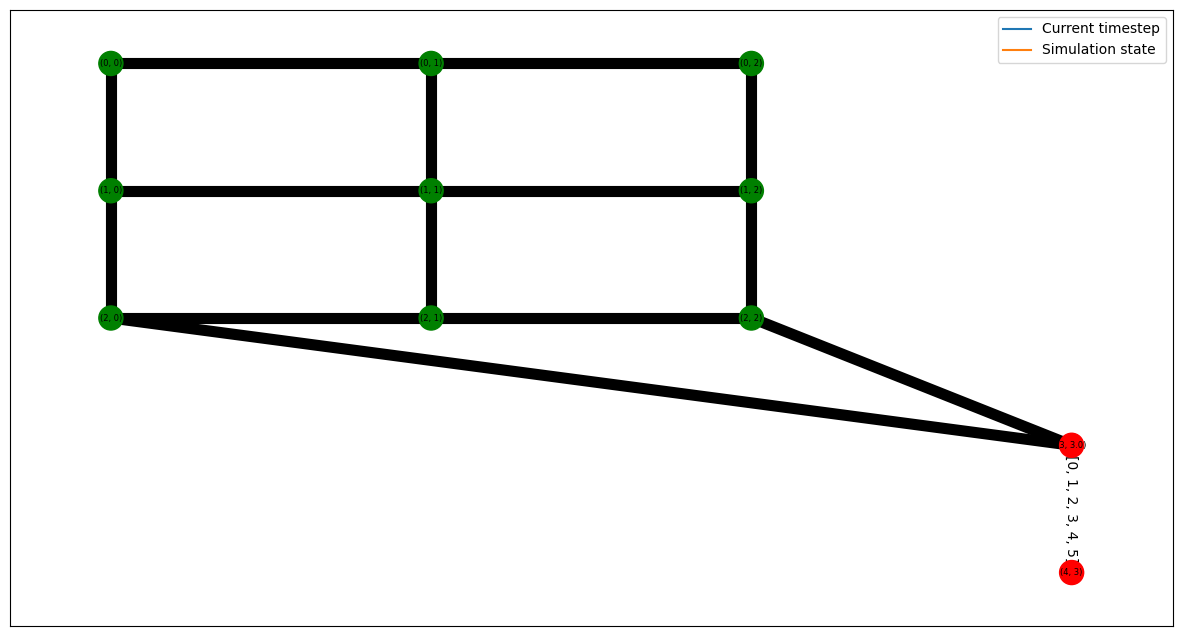


time step: 20, gate (4, 2) is executed,
move_list [5]
move len 1


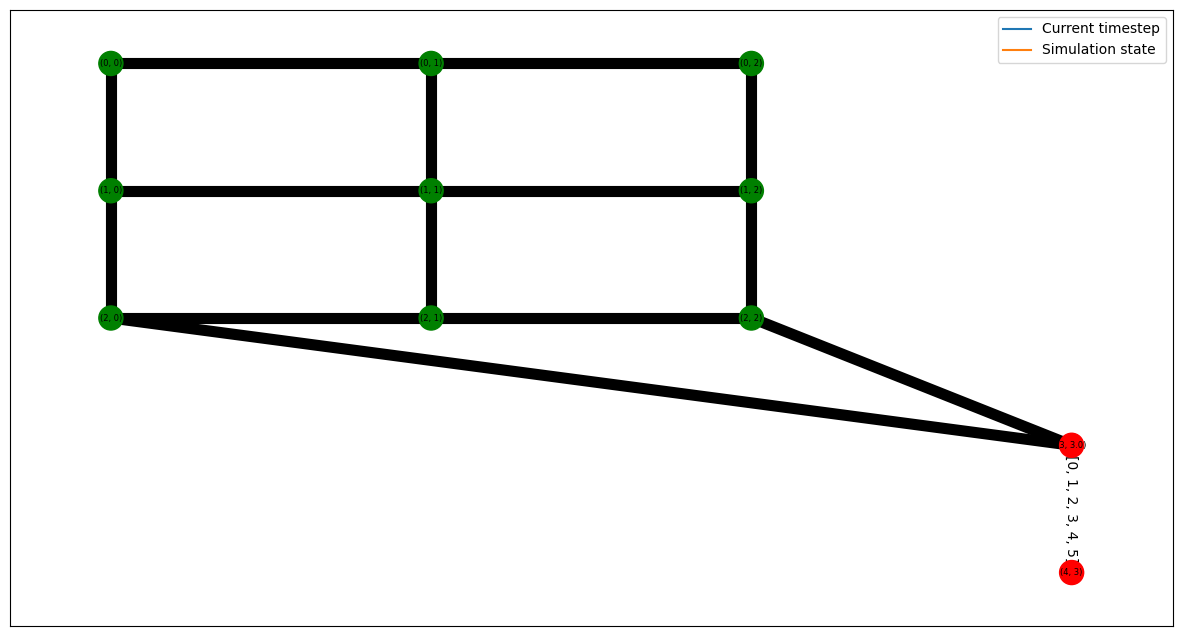


time step: 24, gate (5, 1) is executed,
move_list [5]
move len 1


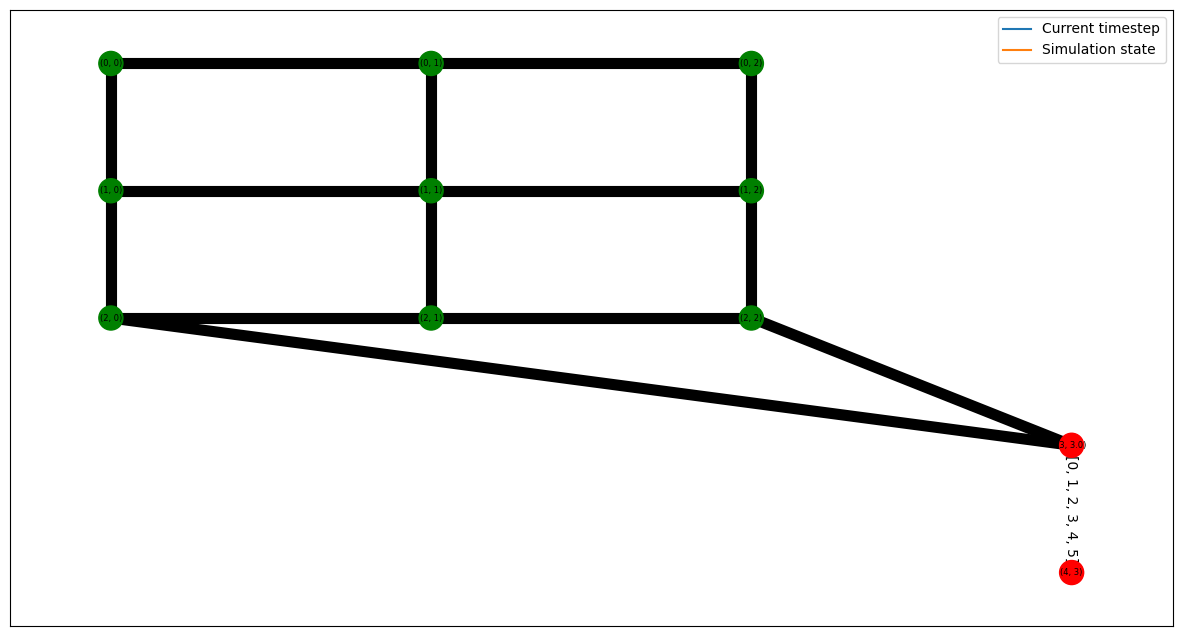


time step: 24, gate (5, 1) is executed,
move_list [5]
move len 1


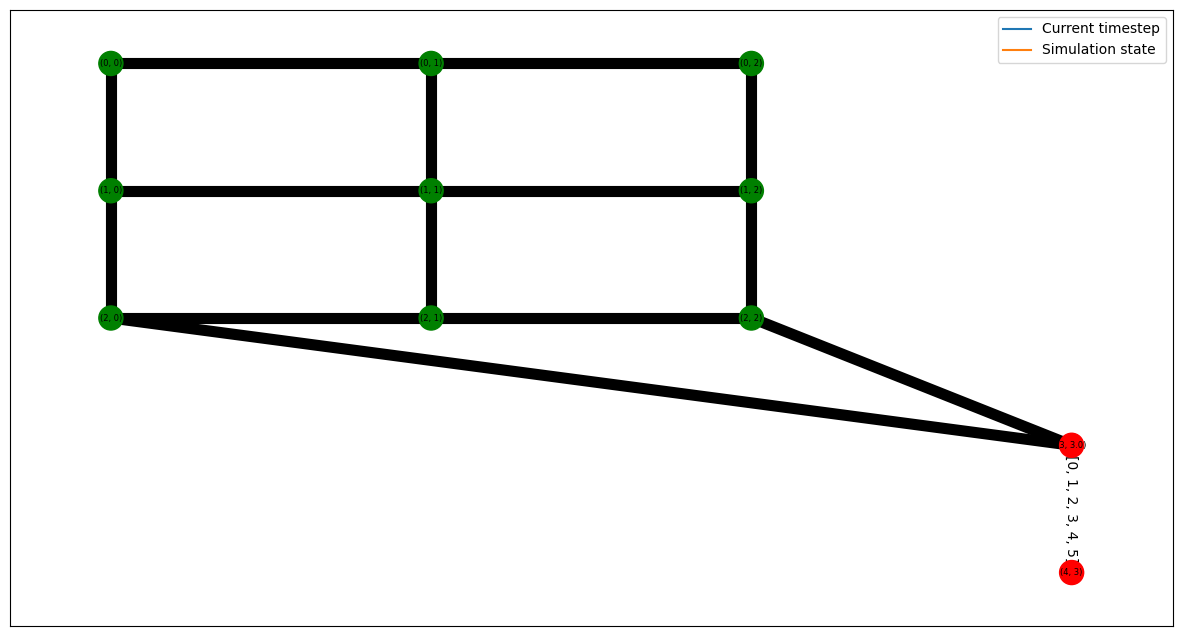


time step: 24, gate (5, 1) is executed,
move_list [4]
move len 1


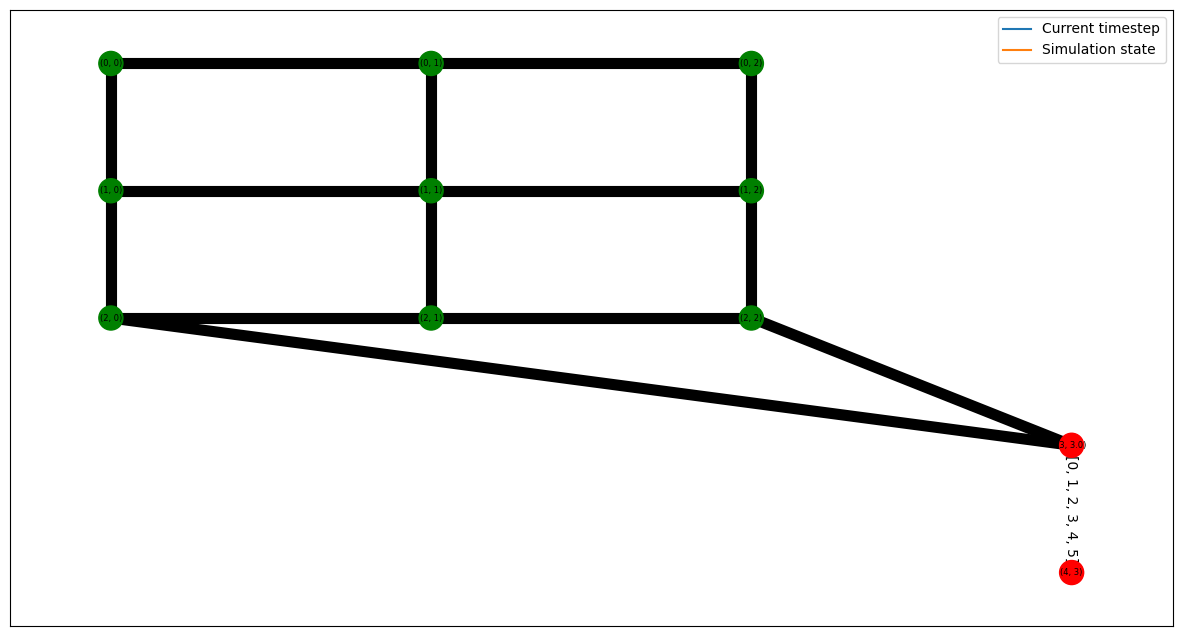


time step: 28, gate (4, 1) is executed,
move_list [4]
move len 1


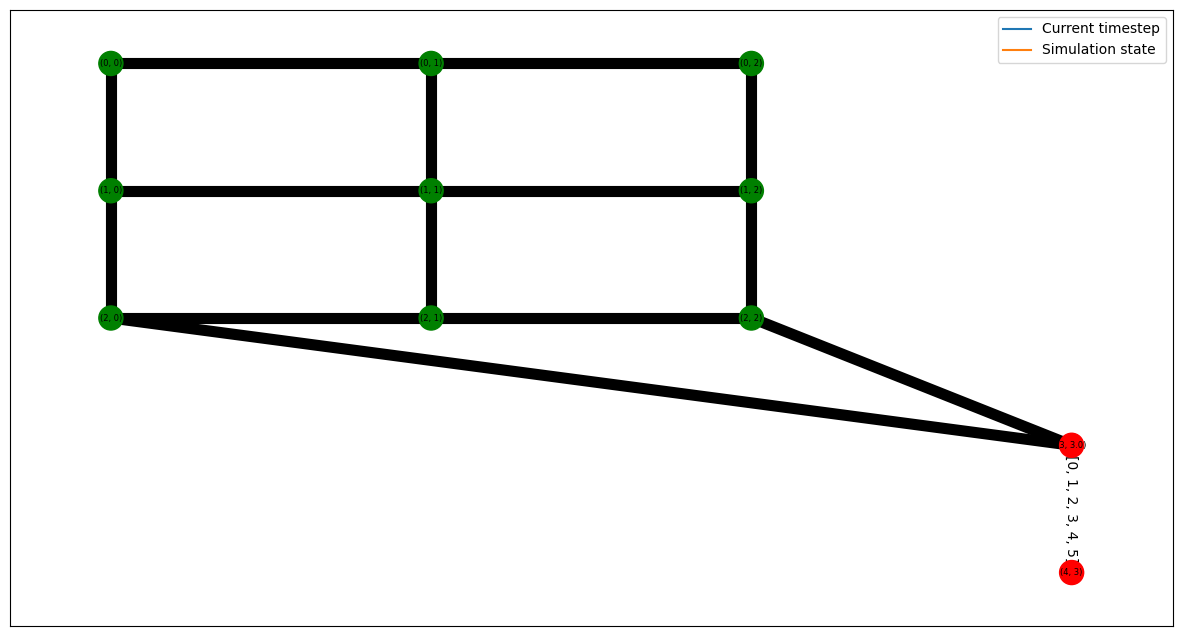


time step: 28, gate (4, 1) is executed,
move_list [4]
move len 1


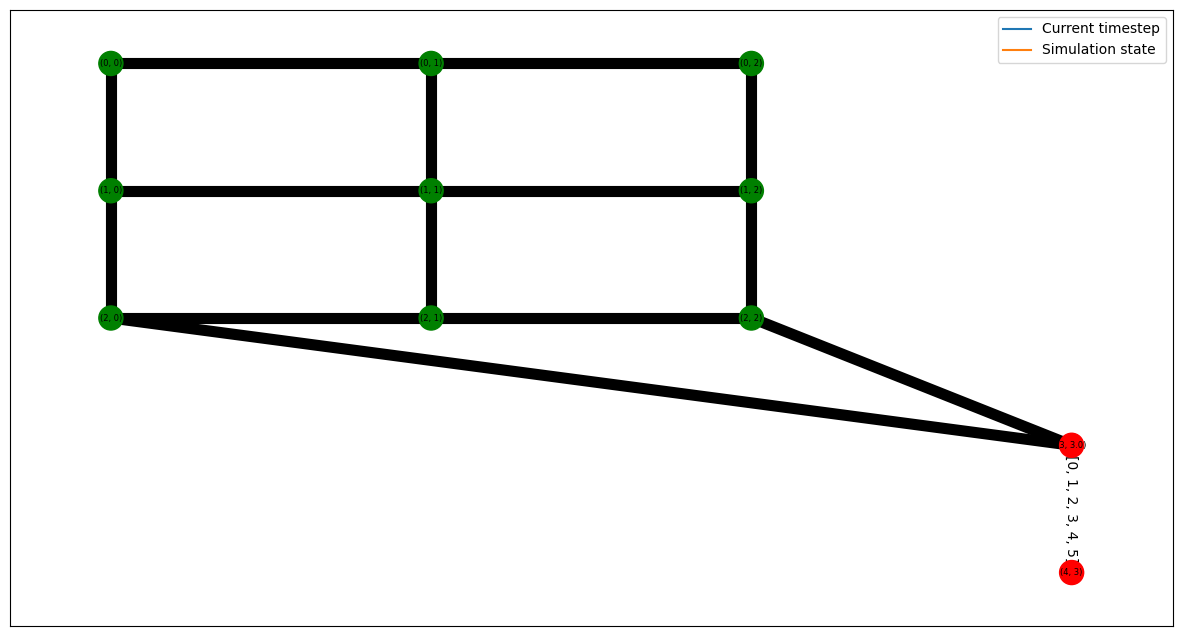


time step: 28, gate (4, 1) is executed,
move_list [5]
move len 1


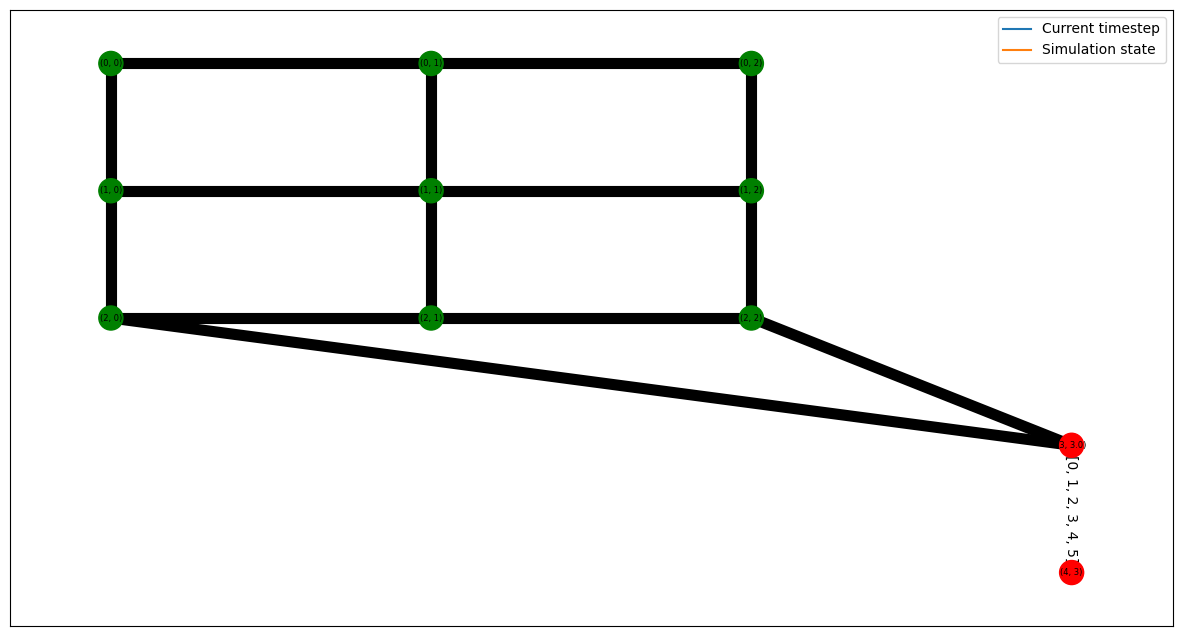


time step: 32, gate (5, 0) is executed,
move_list [5]
move len 1


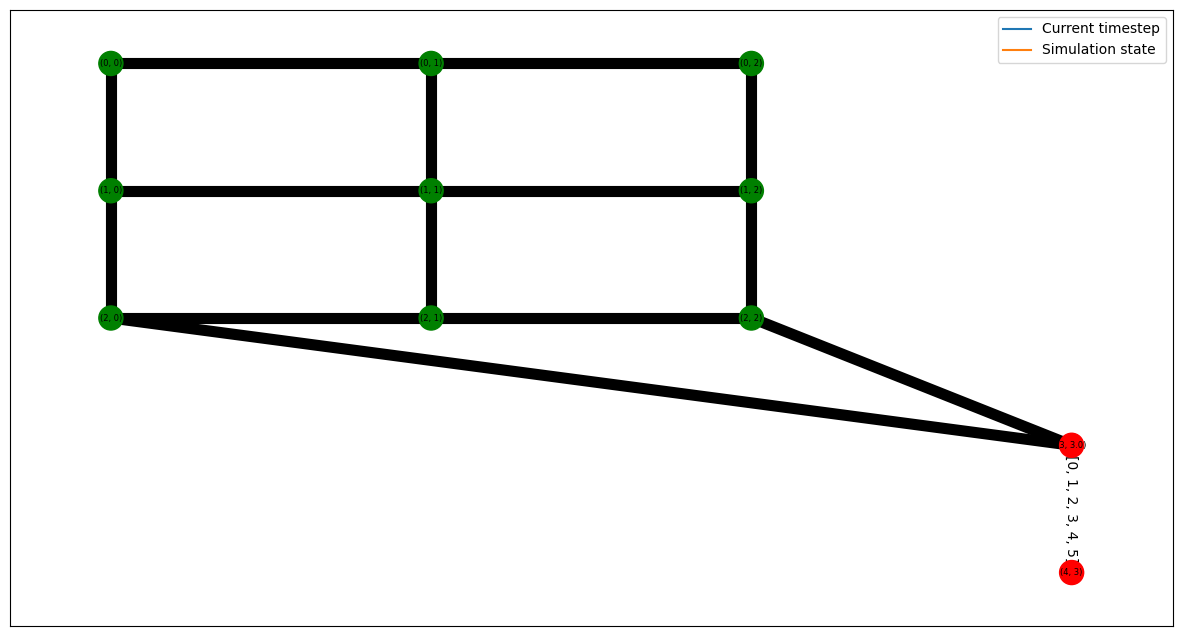


time step: 32, gate (5, 0) is executed,
move_list [5]
move len 1


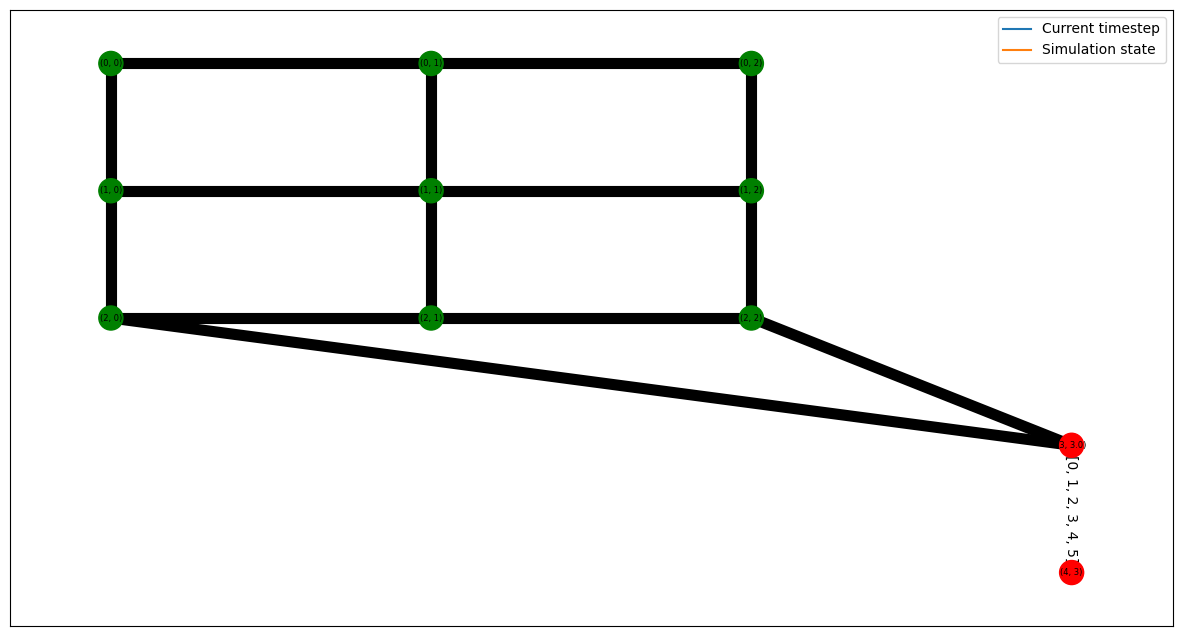


time step: 32, gate (5, 0) is executed,
move_list [4]
move len 1


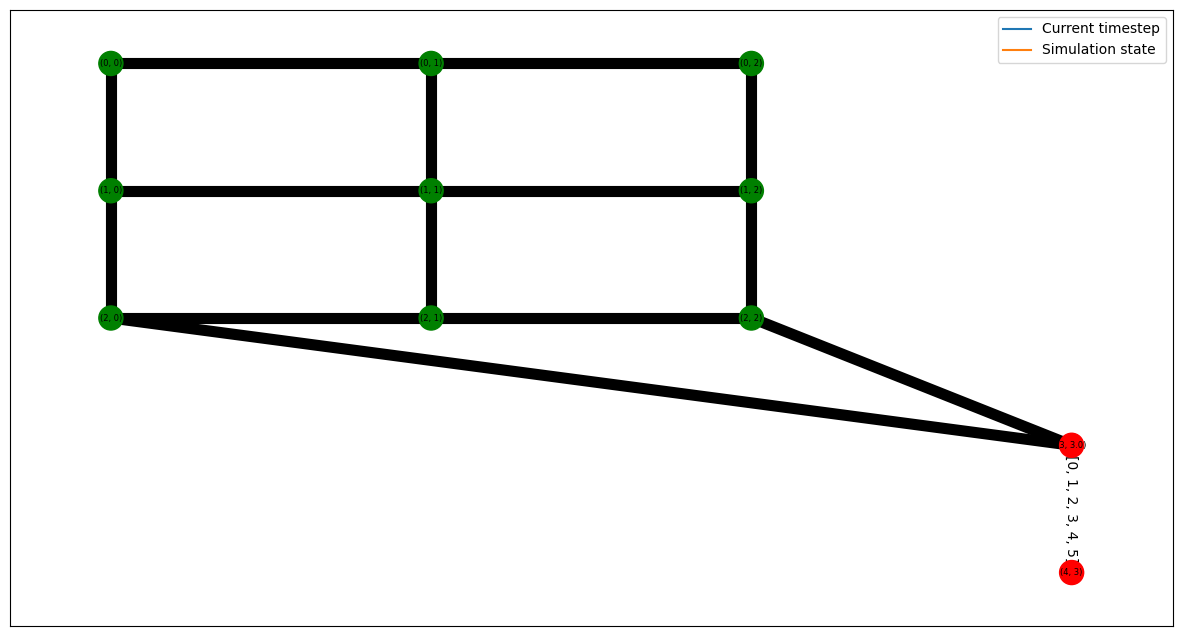


time step: 36, gate (4, 0) is executed,
move_list [4]
move len 1


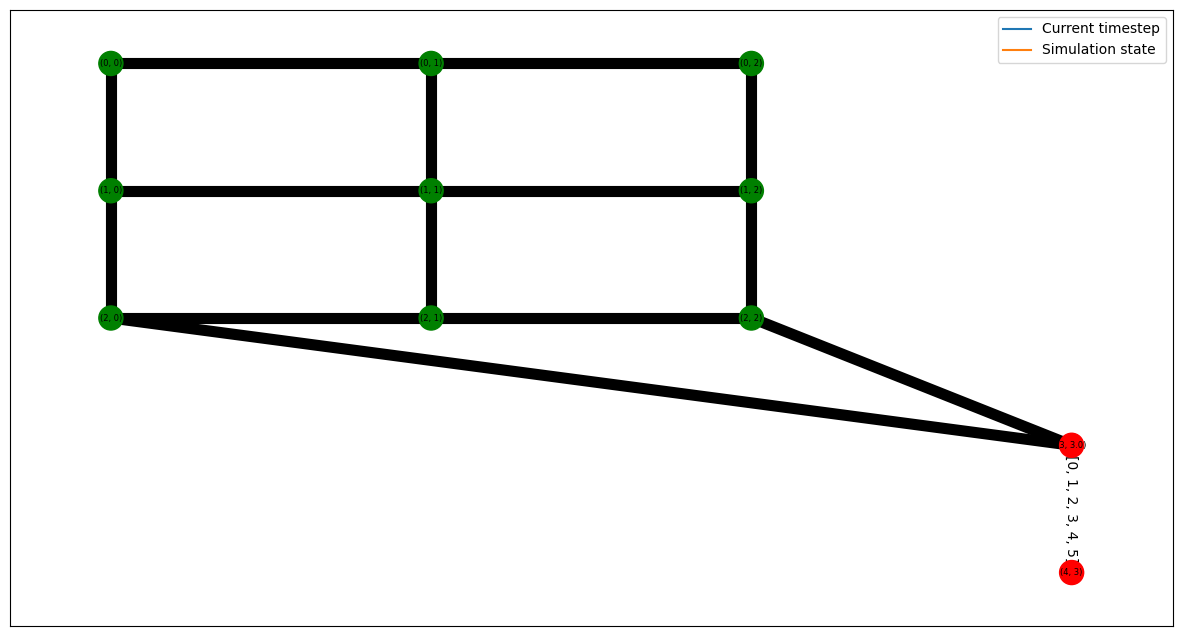


time step: 36, gate (4, 0) is executed,
move_list [4]
move len 1


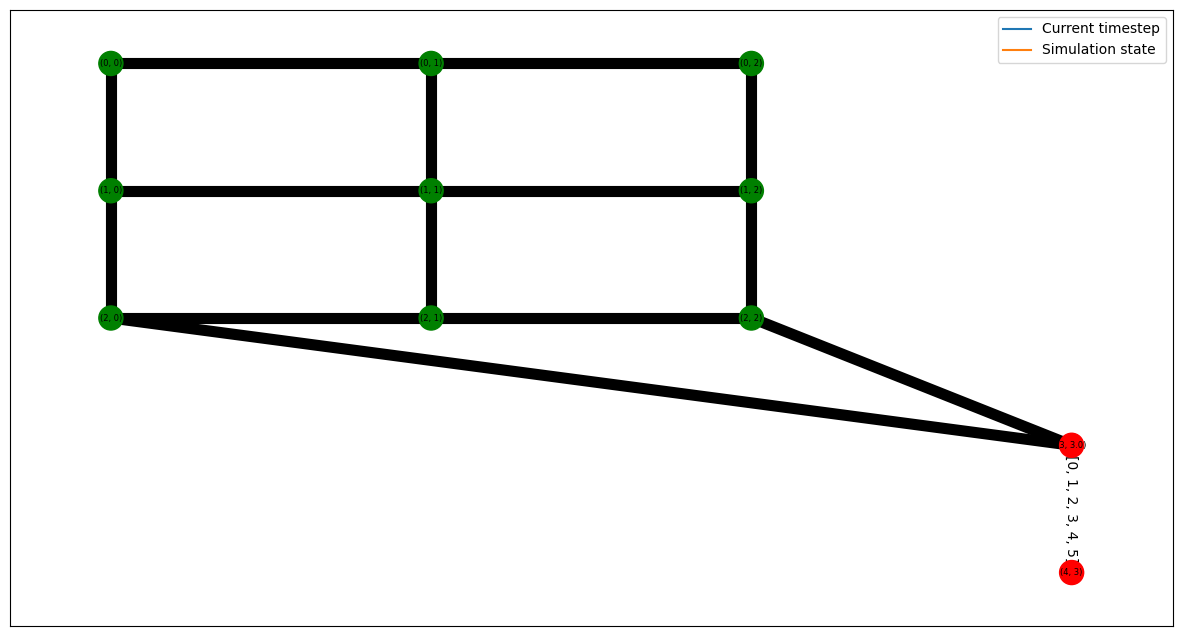


time step: 36, gate (4, 0) is executed,
move_list [3]
move len 1


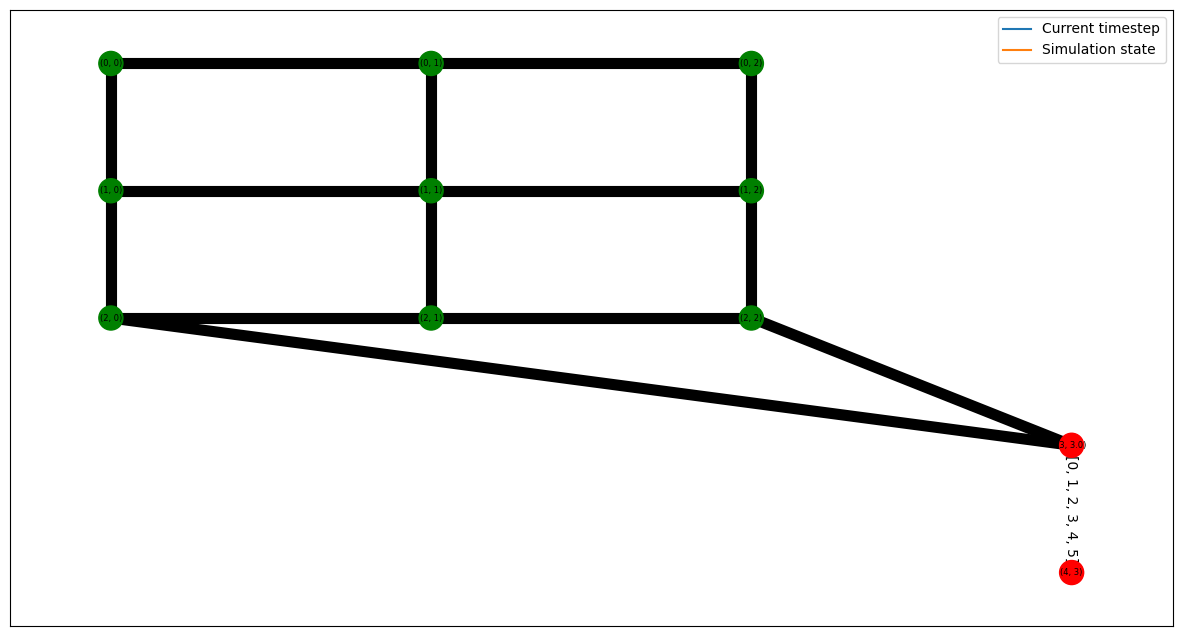


time step: 40, gate (3,) is executed,
move_list [3]
move len 1


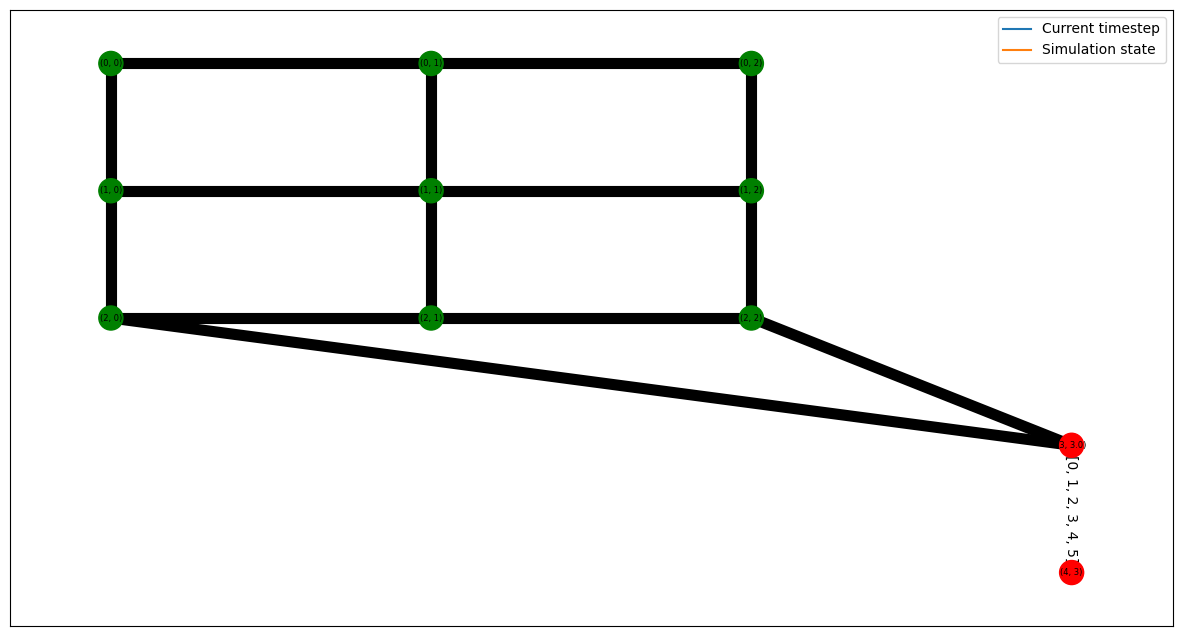


time step: 42, gate (3, 2) is executed,
move_list [3]
move len 1


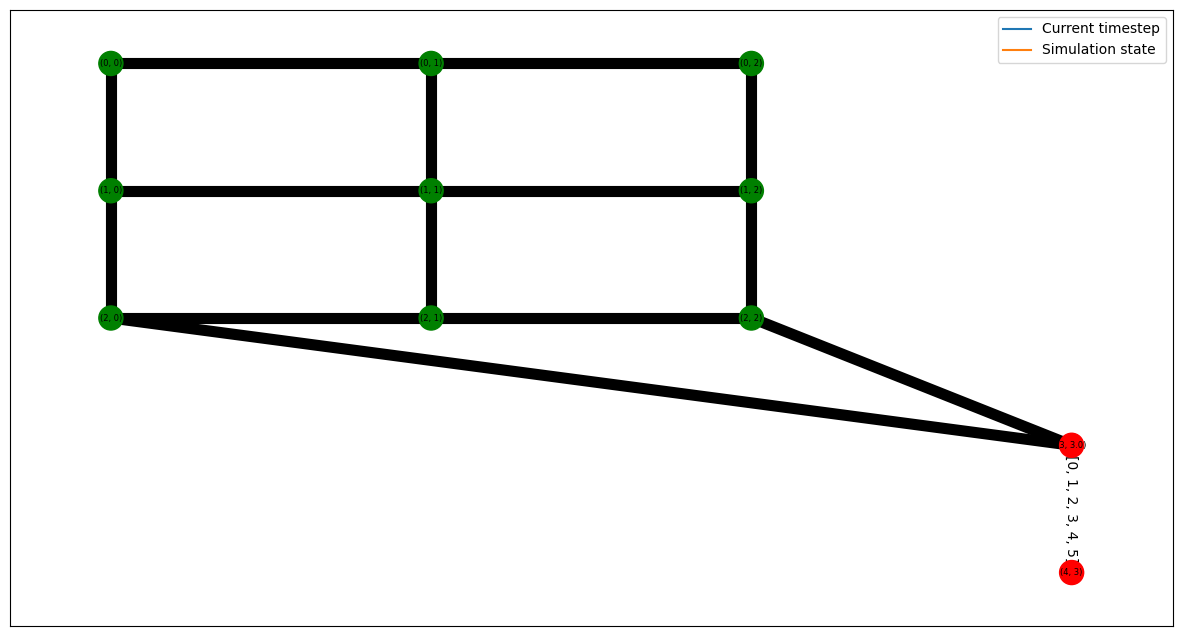


time step: 42, gate (3, 2) is executed,
move_list [3]
move len 1


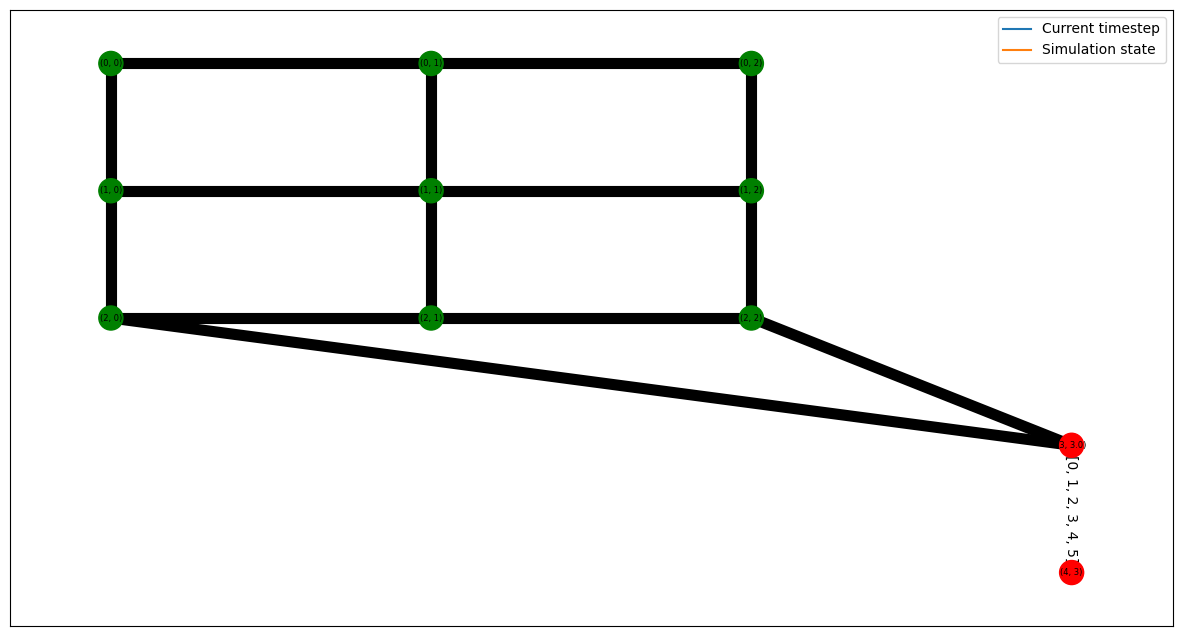


time step: 42, gate (3, 2) is executed,
move_list [3]
move len 1


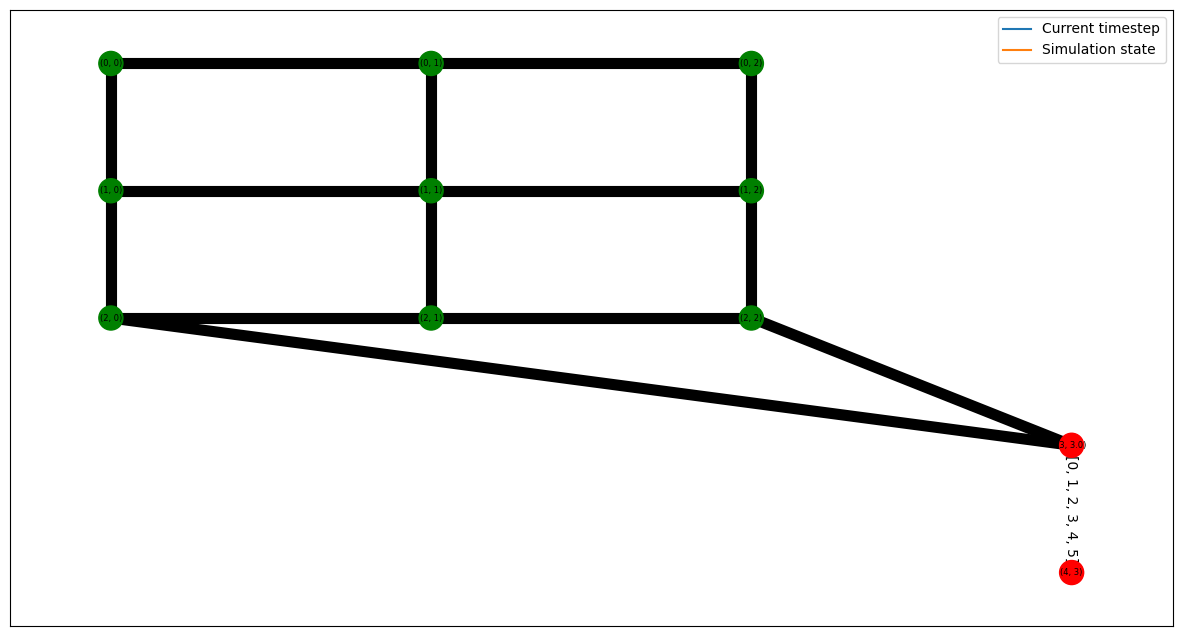


time step: 46, gate (3, 1) is executed,
move_list [3]
move len 1


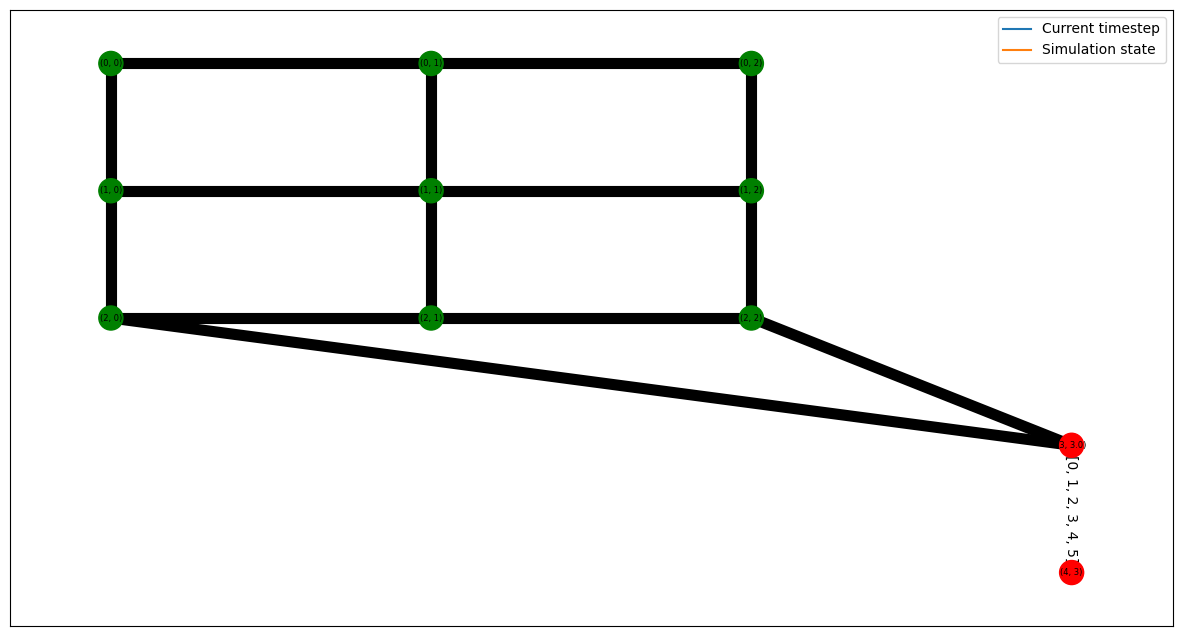


time step: 46, gate (3, 1) is executed,
move_list [3]
move len 1


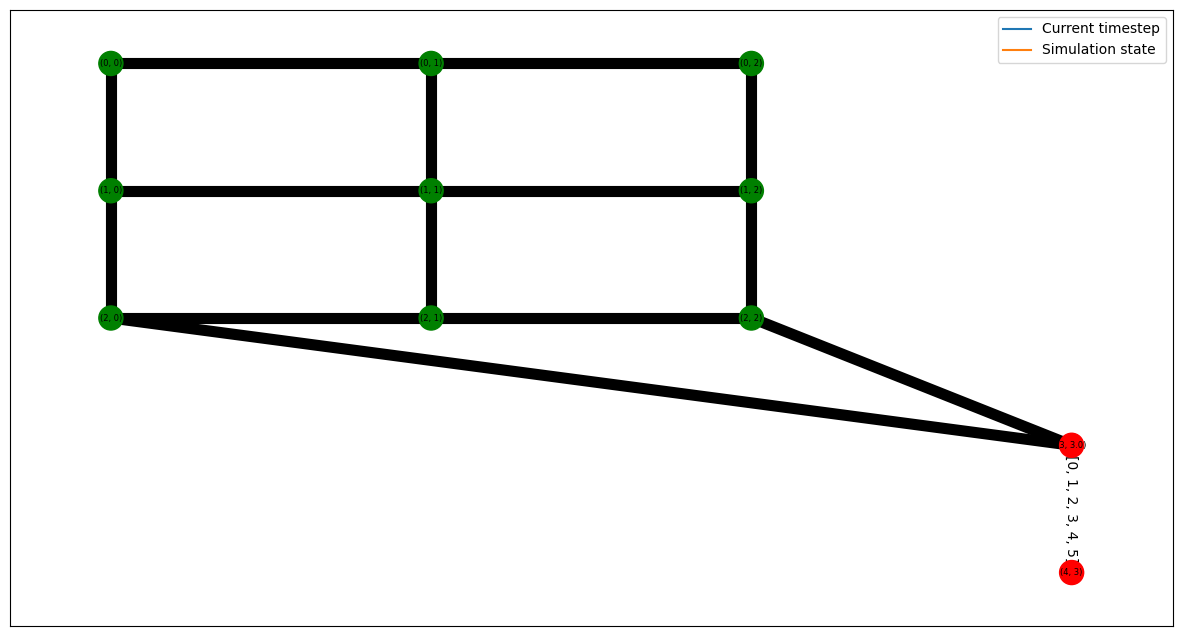


time step: 46, gate (3, 1) is executed,
move_list [3]
move len 1


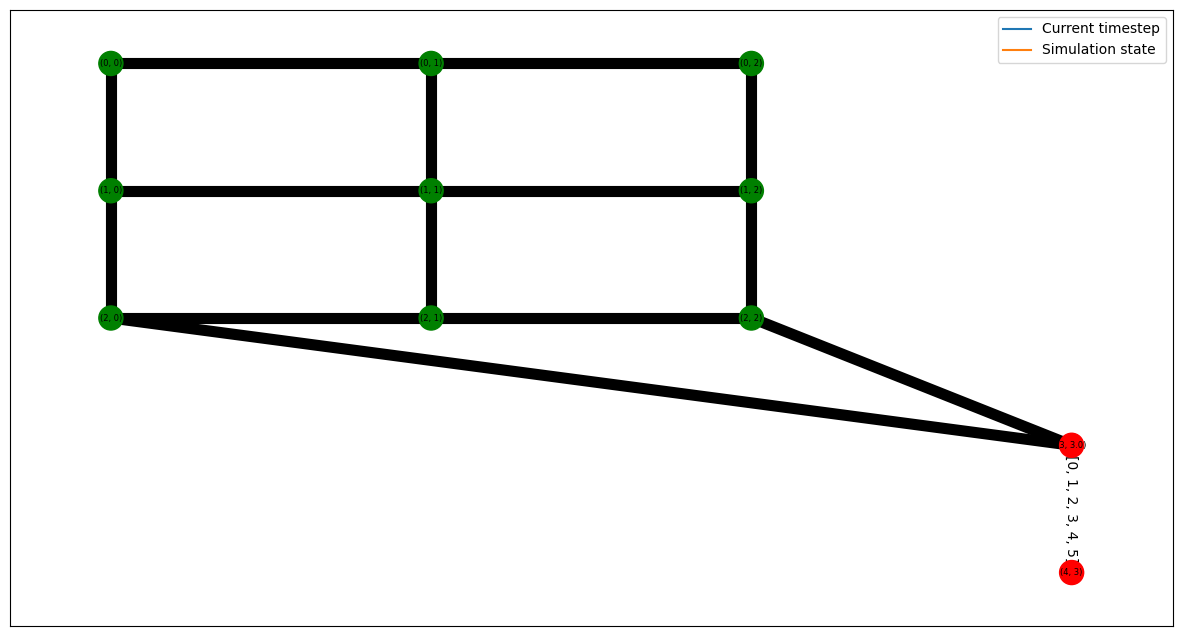


time step: 50, gate (3, 0) is executed,
move_list [3]
move len 1


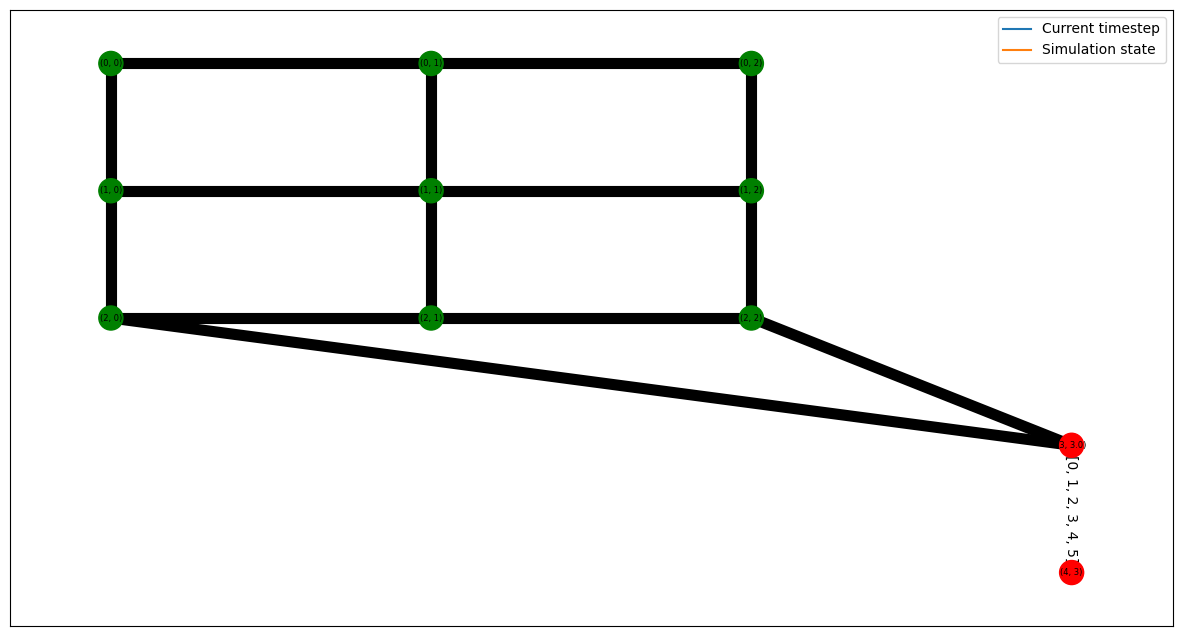


time step: 50, gate (3, 0) is executed,
move_list [3]
move len 1


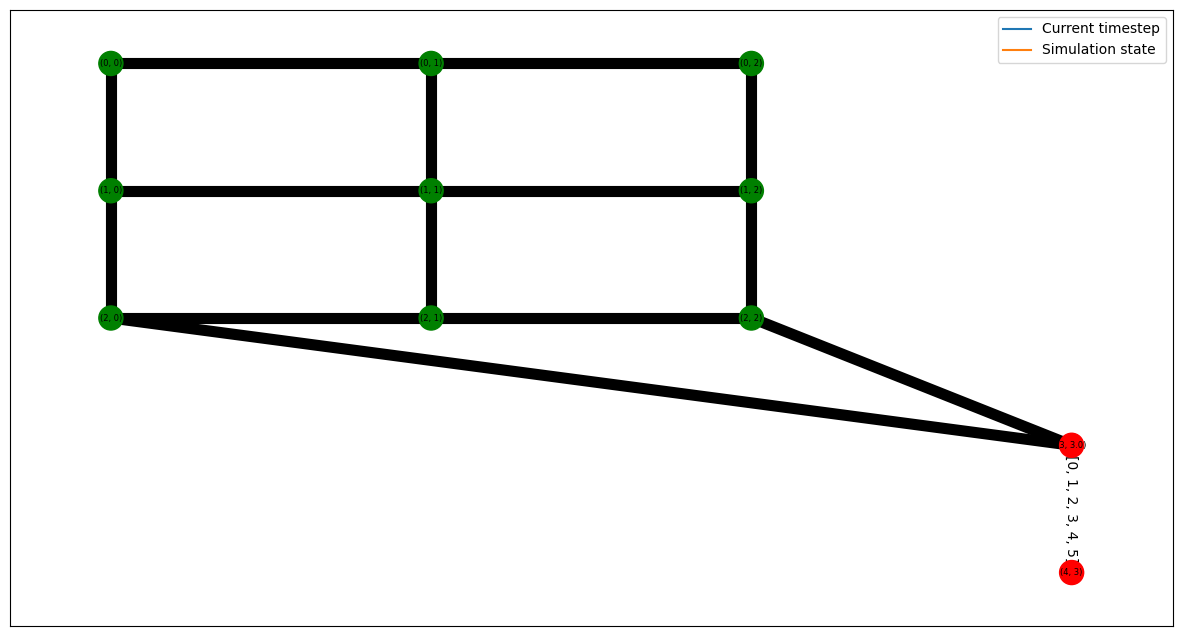


time step: 50, gate (3, 0) is executed,
move_list [2]
move len 1


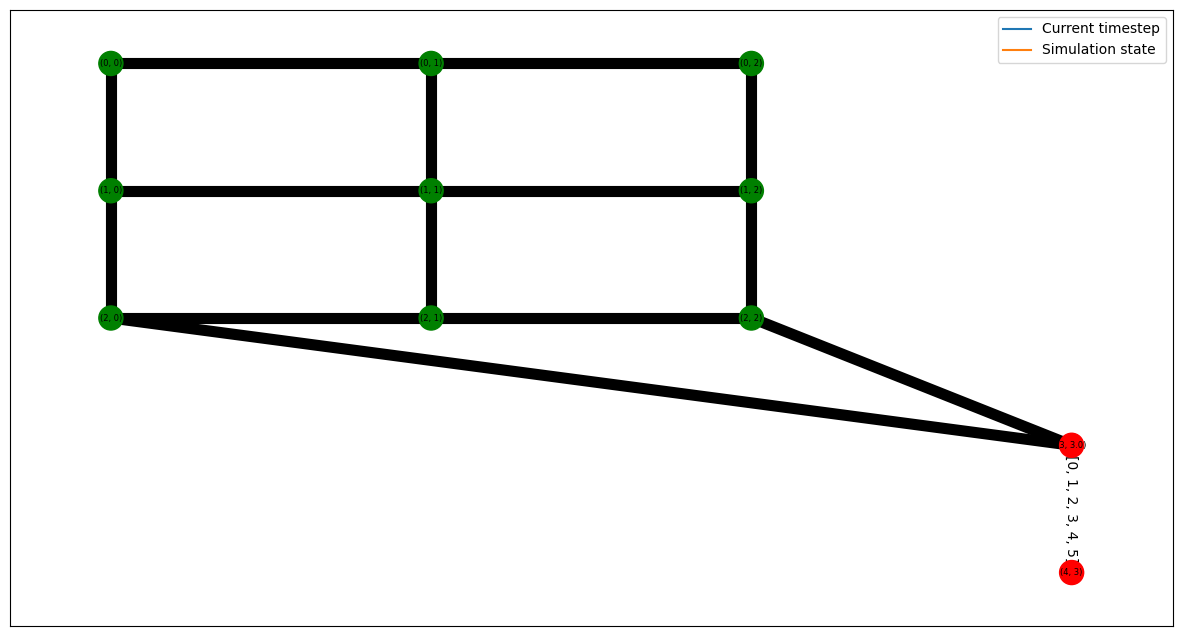


time step: 54, gate (2,) is executed,
move_list [2]
move len 1


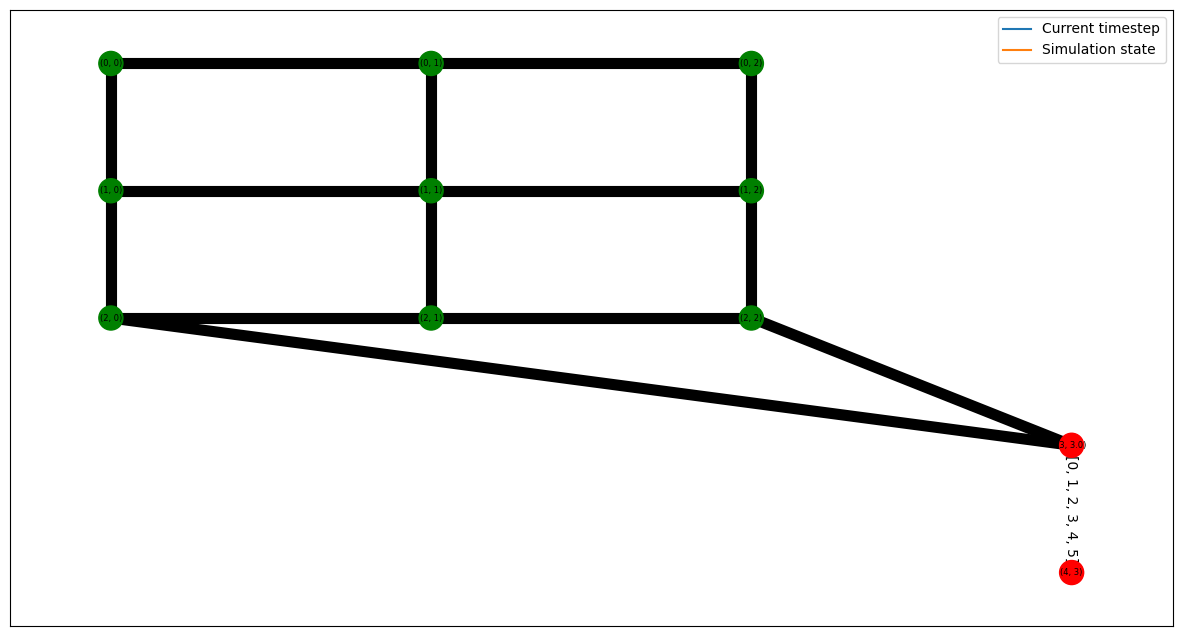


time step: 56, gate (2, 1) is executed,
move_list [2]
move len 1


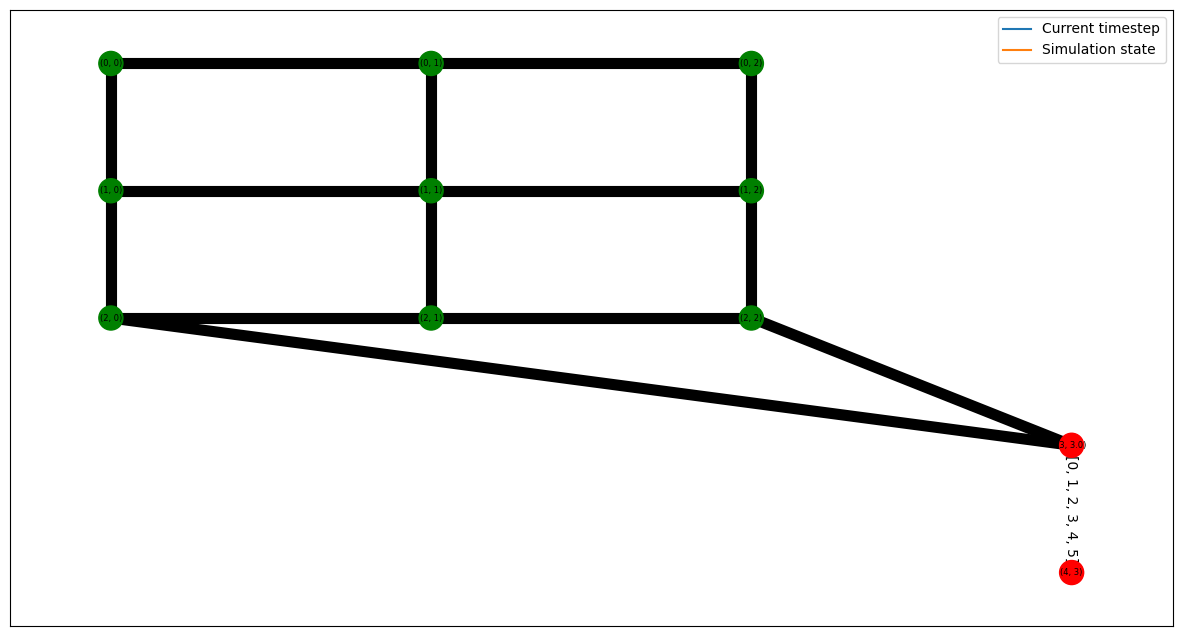


time step: 56, gate (2, 1) is executed,
move_list [2]
move len 1


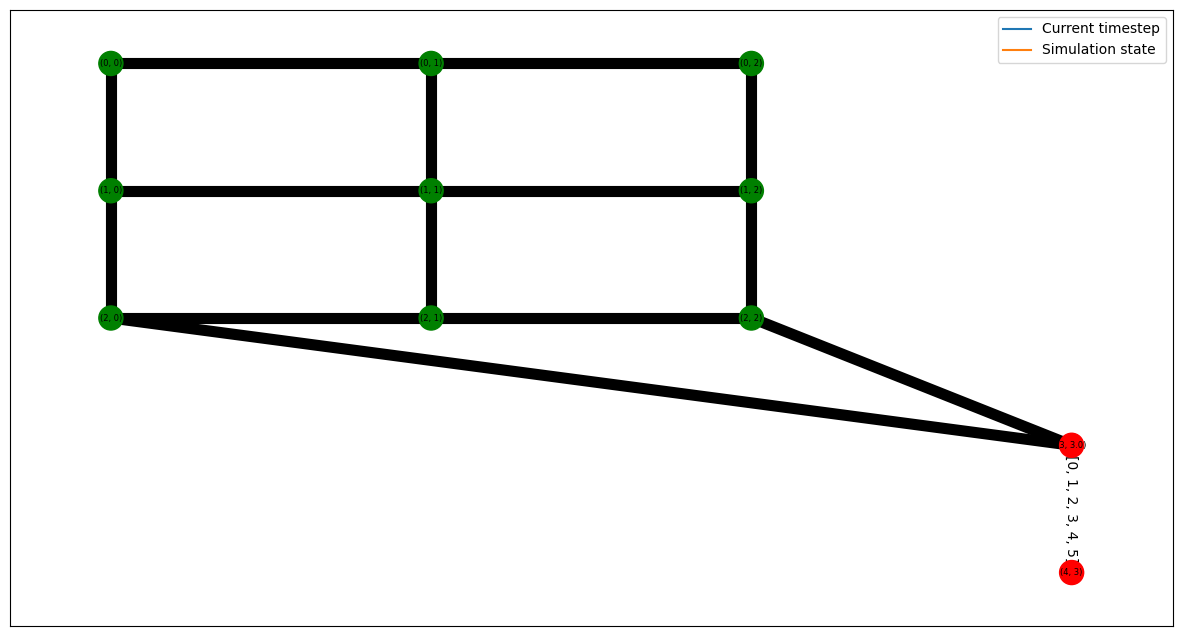


time step: 56, gate (2, 1) is executed,
move_list [2]
move len 1


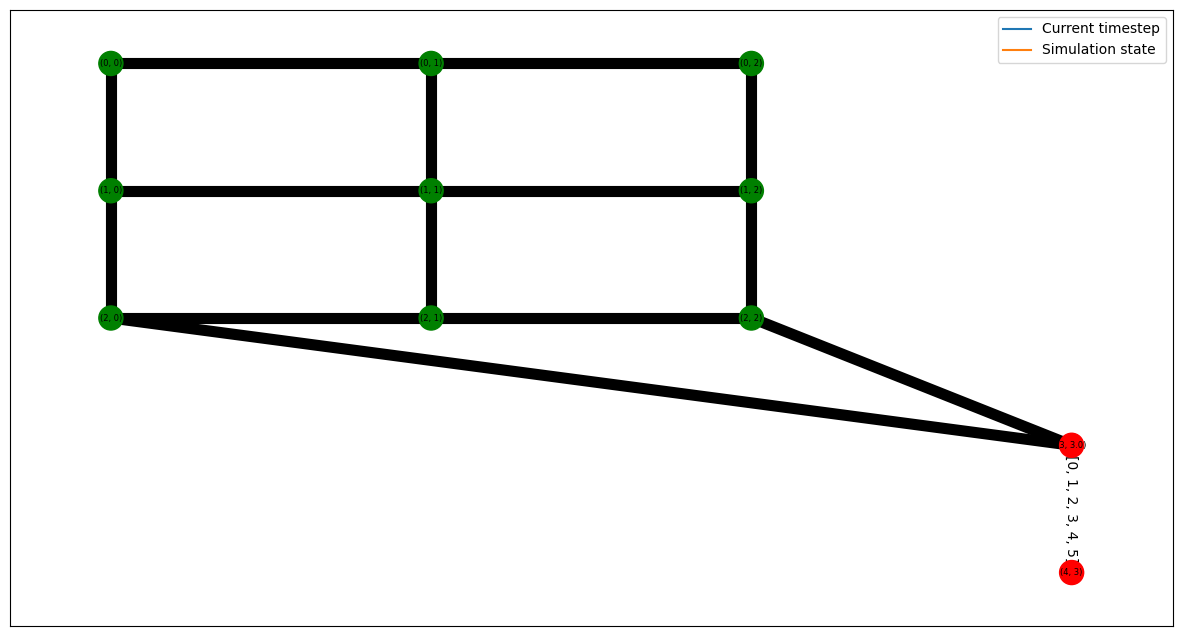


time step: 60, gate (2, 0) is executed,
move_list [2]
move len 1


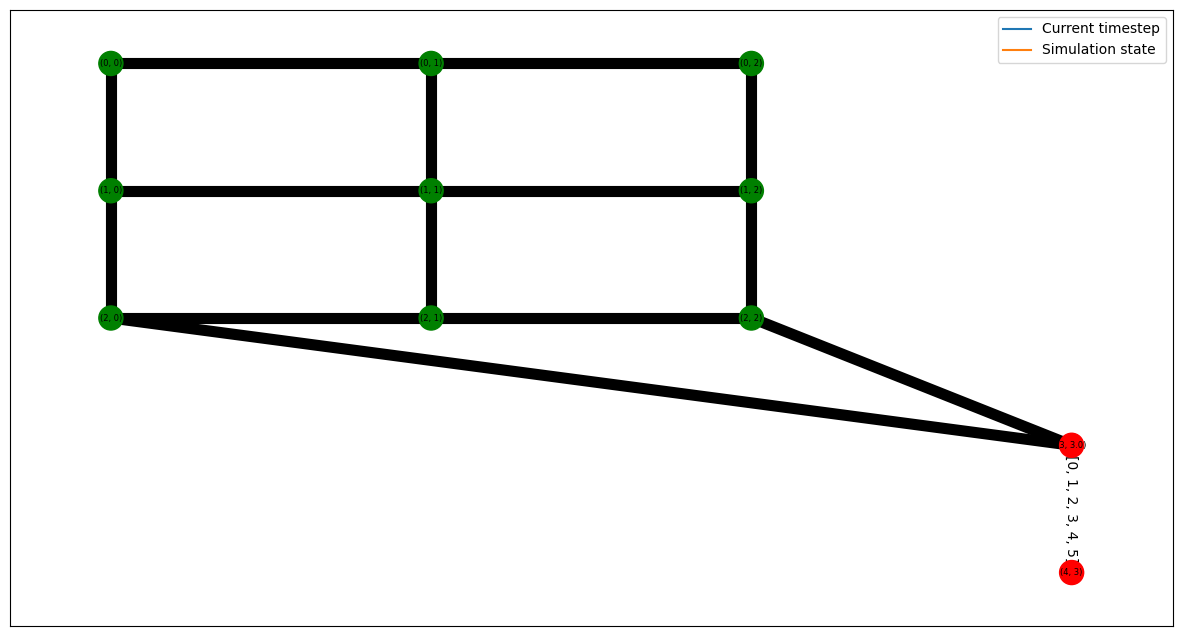


time step: 60, gate (2, 0) is executed,
move_list [2]
move len 1


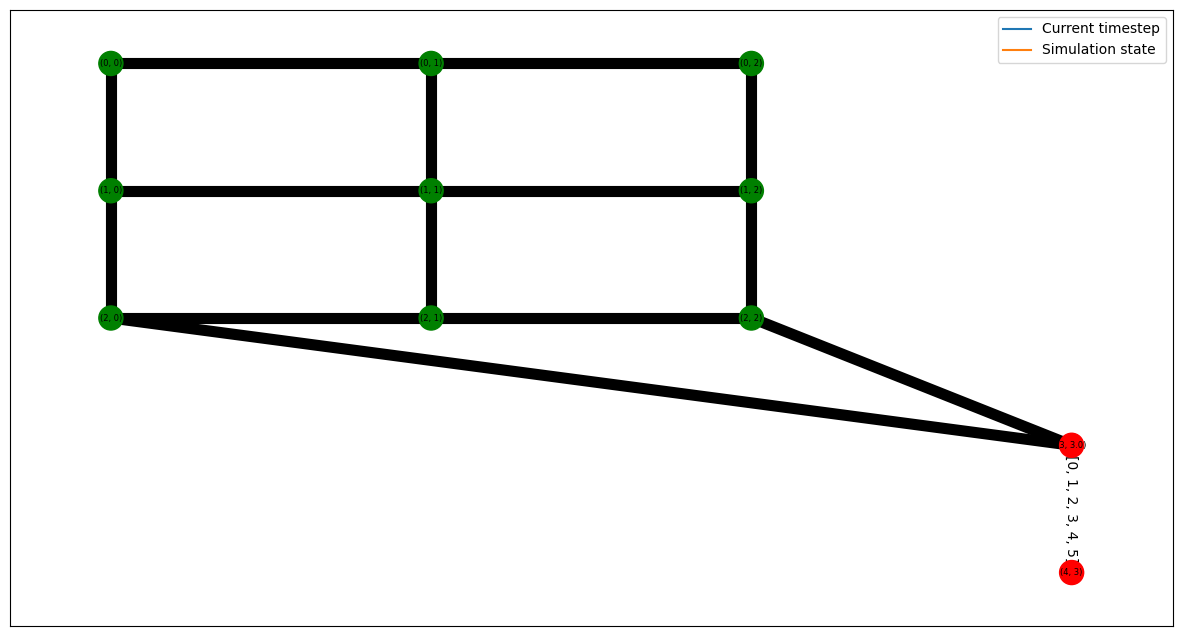


time step: 60, gate (2, 0) is executed,
move_list [1]
move len 1


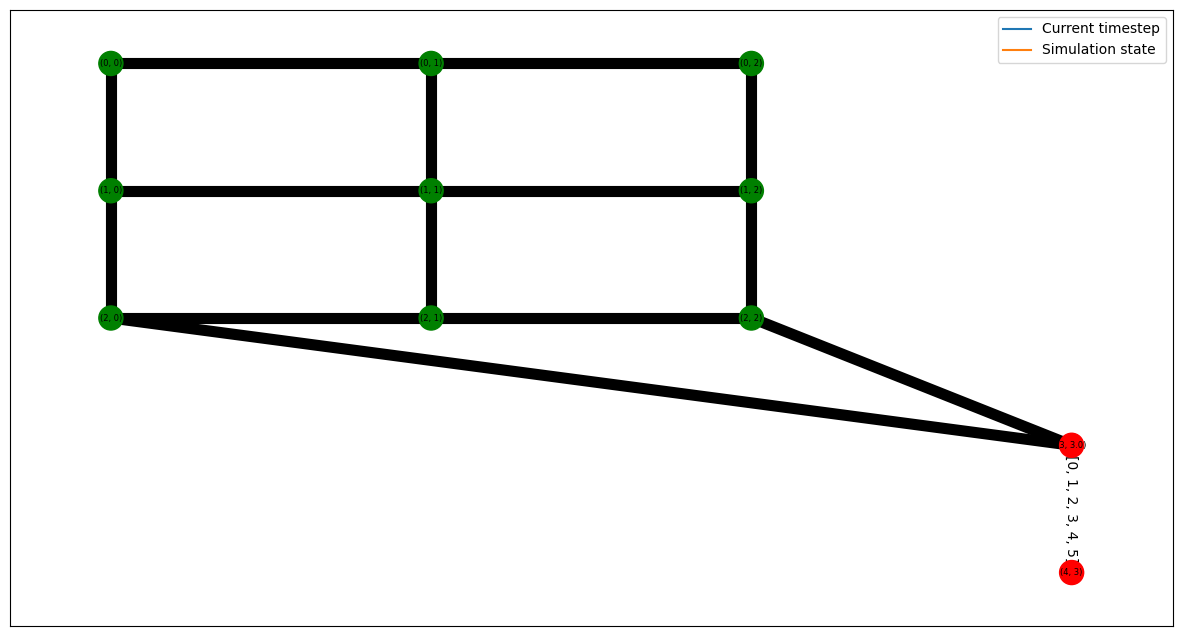


time step: 64, gate (1,) is executed,
move_list [1]
move len 1


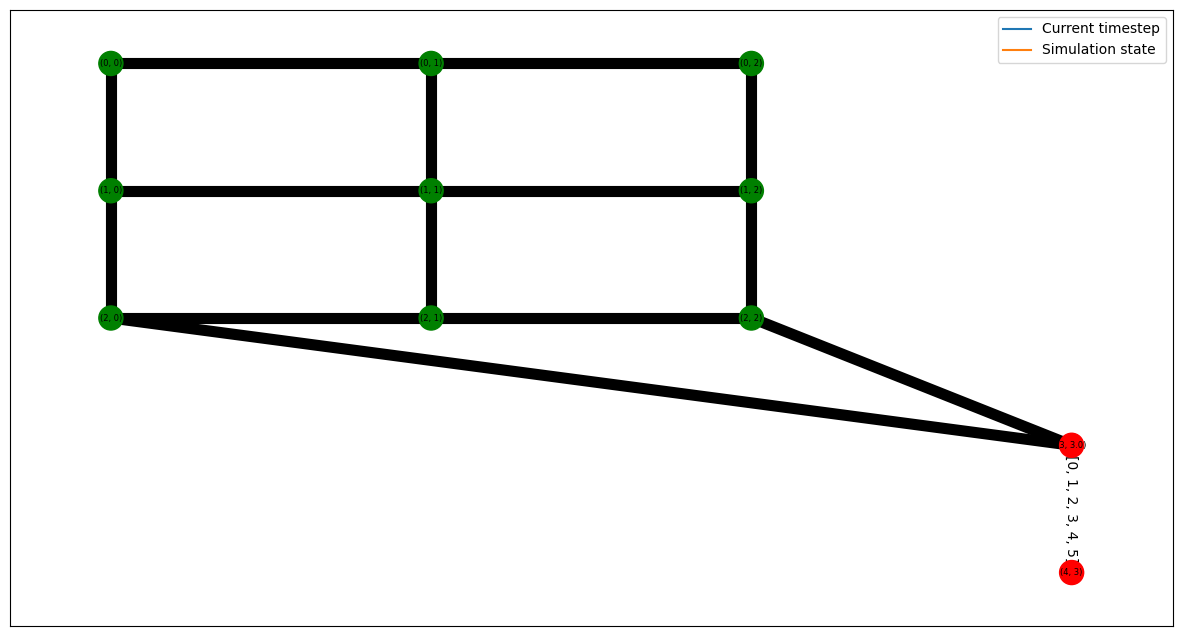


time step: 66, gate (1, 0) is executed,
move_list [1]
move len 1


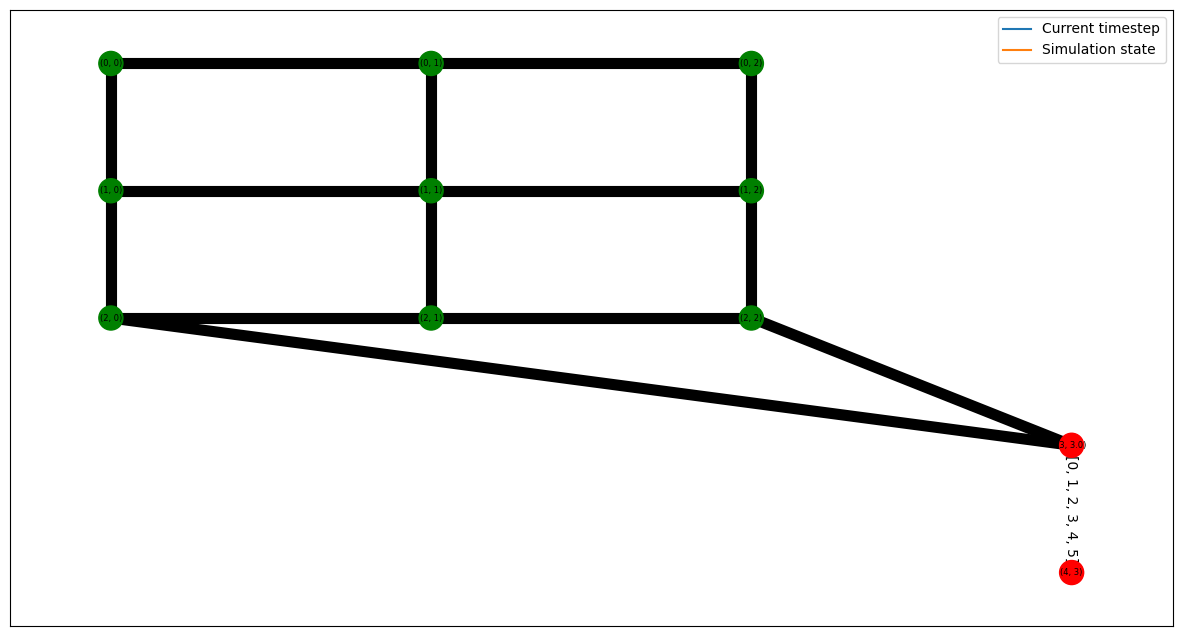


time step: 66, gate (1, 0) is executed,
move_list [1]
move len 1


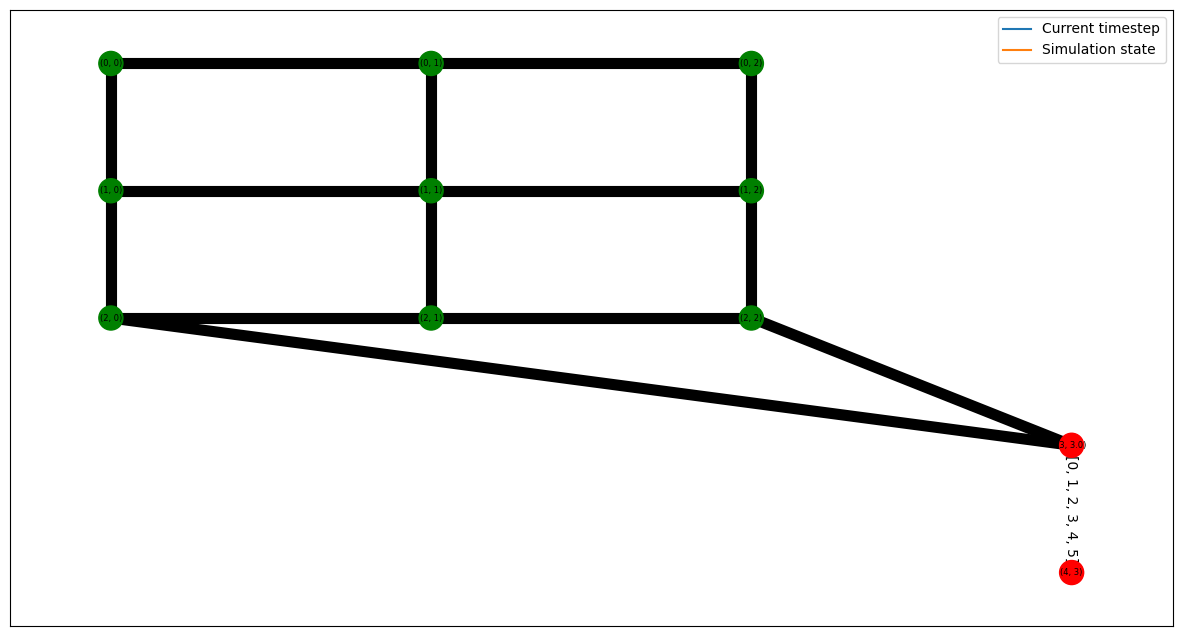


time step: 66, gate (1, 0) is executed,
move_list [0]
move len 1


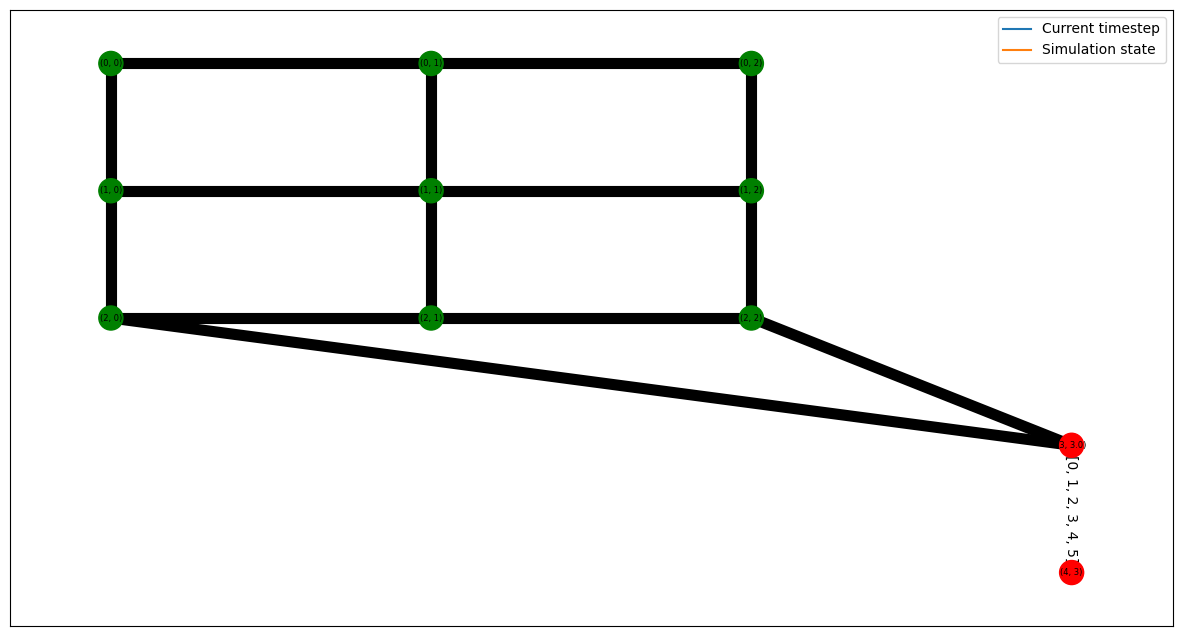


time step: 70, gate (0,) is executed,

Full Sequence executed in 70 time steps


In [8]:
from run_heuristic import create_initial_sequence, run_simulation
# MemoryZoneのインスタンス作成
iontrap = MemoryZone(
    m, n, v, h, ion_chains, max_timesteps, 3,
    time_2qubit_gate=3, time_1qubit_gate=1
)

iontrap.update_distance_map()
distance_map = iontrap.distance_map
# print(distance_map)

# 初期シーケンスの生成
seq, flat_seq, dag_dep, next_node = create_initial_sequence(distance_map, filename)
print(f"Initial sequence: {seq}")
print(f"Flat sequence: {flat_seq}")
print(f"DAG dependency: {dag_dep}")
print(f"Next node: {next_node}")


# シミュレーションの実行
run_simulation(iontrap, max_timesteps, seq, flat_seq, dag_dep, next_node, max_length=10, time_1qubit_gate=1, time_2qubit_gate=3)